# importok + adat

In [396]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  
import os
import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix, f1_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer

In [2]:
with open('model_ready_dict.pickle', 'rb') as handle:
    model_ready_dict = pickle.load(handle)

In [3]:
def convert_decimal_odds_to_probabilities(dfs_dict, odds_columns):

    for key, df in dfs_dict.items():
        for col in odds_columns:
            df[f'prob_{col}'] = 1 / df[col]  
    return dfs_dict

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
model_ready_dict = convert_decimal_odds_to_probabilities(model_ready_dict, odds)

In [4]:
for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [45]:
big5 = pd.read_excel("big5_sorted_by_date.xlsx")
big5.drop(columns='Unnamed: 0', inplace=True)

def convert_odds_big5(df, odds_columns):
    for col in odds_columns:
        df[f'prob_{col}'] = 1 / df[col]
    return df

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']
big5 = convert_odds_big5(big5, odds)

# Végeredmény

## PL, full time result

### első lépés - finomhangolás

In [223]:
def random_forest_tuning(df, target_col, drop_cols=[]):
    
    """Ez a függvény a hiperparaméterillesztő Random Forest.
    
    df = a tisztított df, 6 lehetőség van: a top 5 liga külön, és egy kombinált df
    target_col = az előrejelezni kívánt változó
    drop_cols = a többi célváltozó, amiket szintén el kell távolítani
    """
    
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]

    """A tanulóhalmaz 80%, a validációs 10%.
    A sorrendiség megmarad, a print parancsok ezt hivatottak leellenőrizni.
    """
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))

    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 

    print(f"tanító halmaz dimenziók: {train_set.shape}")
    print(f"validációs halmaz dimenziók: {val_set.shape}")
        
    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    """A hiperparaméter grid. Próbáltam több hiperparaméterrel,
    de az rengeteg idő volt, és nem érte meg.
    A keresztvalidációs függvény a TimeSeriesSplit(), amely kifejezetten 
    temporális adatokra van kitalálva.
    """
    
    param_space = {
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(10, 50),       
        'min_samples_split': Integer(2, 20), 
        'min_samples_leaf': Integer(1, 20), 
        'criterion': ['gini', 'entropy'],     
        'max_features': ['sqrt', 'log2']     
    }
    
    rf = RandomForestClassifier(random_state=1)
    
    bayes_search = BayesSearchCV(
        estimator=rf,
        search_spaces=param_space,
        n_iter=30,  
        scoring='f1',  
        refit='f1',
        cv=TimeSeriesSplit(n_splits=5),  
        verbose=0,
        n_jobs=-1,  
        random_state=1
    )

    """A Random Forest algoritmus behívása, validációs halmazra illesztése-
    Továbbá lementem a 15 legfontosabb paramétert, előrejelzést adok a validációs halmazon
    a célváltozóra, és az egyes kimenetelek valószínűségeit is lementjük. 
    
    A kód legvégén egy modell teljeseítményét összegző report és egy konfúziós mx van.
    """
    
    bayes_search.fit(X_train, y_train)  

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    print("\nlegjobb modell hiperparameterei:", best_params)

    y_pred = best_model.predict(X_val)
    val_set = val_set.copy()
    val_set.loc[:, 'Predicted'] = y_pred

    accuracy = accuracy_score(y_val, y_pred)
    print(f"accuracy: {accuracy:.4f}")
    
    y_val_probs = best_model.predict_proba(X_val)
    
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  
    
    print("\nösszegzés:")
    print(classification_report(y_val, y_pred))

    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()

    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    print("\ntop15 valtozo:")
    top_features = feature_importances.head(15)
    print(top_features)
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.xlabel("Változók fontossága")
    plt.ylabel("Változók")
    plt.grid(axis='x')
    plt.show()

    return val_set, best_params, top_features

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 11, 'n_estimators': 900})
accuracy: 0.6649

összegzés:
              precision    recall  f1-score   support

           0       0.64      0.78      0.71       190
           1       0.70      0.54      0.61       180

    accuracy                           0.66       370
   macro avg       0.67      0.66      0.66       370
weighted avg       0.67      0.66      0.66       370



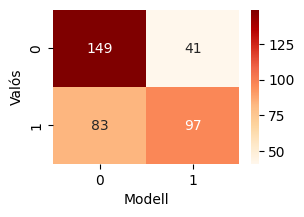


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.074298
54      prob_AwayW_odds_market    0.070109
52                     GD_diff    0.034074
55       prob_Draw_odds_market    0.032775
28     away_expected_points_RA    0.030079
31    away_np_xg_difference_RA    0.029195
51      cumulative_points_diff    0.028448
30               away_np_xg_RA    0.028059
13  home_cumulative_goals_diff    0.026684
56       prob_U2.5_odds_market    0.026314
29                  away_xg_RA    0.026270
9     home_np_xg_difference_RA    0.024674
32                away_ppda_RA    0.024124
57       prob_O2.5_odds_market    0.024024
10                home_ppda_RA    0.023342


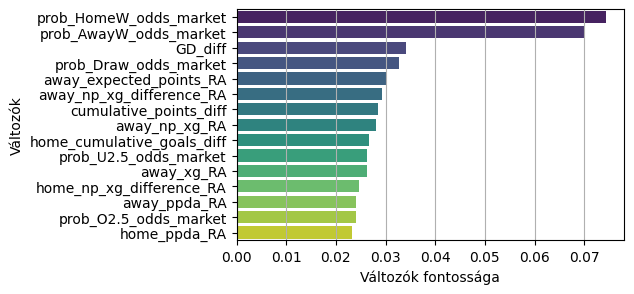

In [224]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

premier_league_tuned_home, premier_league_params_home, premier_league_top_features_home = random_forest_tuning(premier_league,
                                                                                                               target_col,
                                                                                                               drop)

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 470})
accuracy: 0.7162

összegzés:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       265
           1       0.50      0.32      0.39       105

    accuracy                           0.72       370
   macro avg       0.63      0.60      0.60       370
weighted avg       0.69      0.72      0.70       370



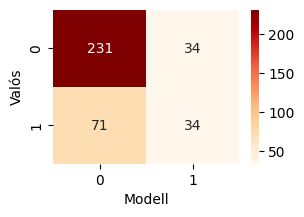


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.076101
54      prob_AwayW_odds_market    0.068963
52                     GD_diff    0.031095
31    away_np_xg_difference_RA    0.030603
51      cumulative_points_diff    0.030455
55       prob_Draw_odds_market    0.029545
33    away_deep_completions_RA    0.028751
30               away_np_xg_RA    0.028558
28     away_expected_points_RA    0.028149
24               away_shots_RA    0.028092
29                  away_xg_RA    0.026309
10                home_ppda_RA    0.023849
32                away_ppda_RA    0.022911
13  home_cumulative_goals_diff    0.022620
9     home_np_xg_difference_RA    0.022516


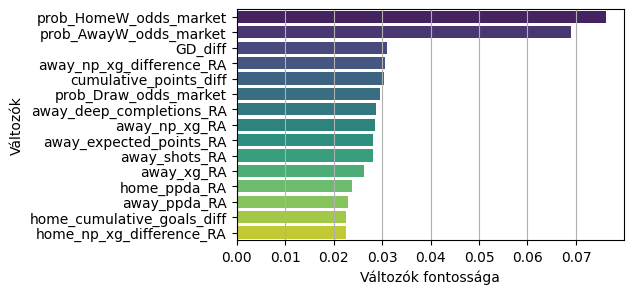

In [219]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

premier_league_tuned_away, premier_league_params_away, premier_league_top_features_away = random_forest_tuning(premier_league,
                                                                                                               target_col,
                                                                                                               drop)

### masodik lepes - legjobb parametereket hasznalo modell inicializalasa

In [239]:
def random_forest_validation(df, target_col, drop_cols=[], best_params={}):

    """
    Ez a második modell: az előzőleg lementett hiperparamétereket (lásd a best_params inputot)
    használja a modell újraillesztéséhez.

    A függvény csak a modellt adja vissza, másra nincs szükség.

    """
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))
    test_n = len(df) - train_n - val_n 
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:] 

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
                
    rf = RandomForestClassifier(
        n_estimators=best_params.get('n_estimators', 500),
        max_depth=best_params.get('max_depth', 10),
        min_samples_split=best_params.get('min_samples_split', 2),
        min_samples_leaf=best_params.get('min_samples_leaf', 1),
        criterion=best_params.get('criterion', 'entropy'),
        max_features=best_params.get('max_features', 'sqrt'),
        random_state=best_params.get('random_state', 1)
    )
    
    rf.fit(X_train, y_train)
    
    return rf

### harmadik lepes - vegso modell, szavazas -- TESZTHALMAZ

In [43]:
# def random_forest_final(df, drop_cols_home=[], drop_cols_away=[], best_params_home={}, best_params_away={}):
#     df = df.dropna().reset_index(drop=True)

#     rf_home = random_forest_validation(df, "target_home_win", drop_cols_home, best_params_home)
#     rf_away = random_forest_validation(df, "target_away_win", drop_cols_away, best_params_away)

#     X_test = df.tail(int(len(df) * 0.1)).reset_index(drop=True)    
#     X_test = X_test.drop(columns=["target_home_win", "target_away_win"] + drop_cols_home + drop_cols_away)

#     model_home_preds = rf_home.predict(X_test)
#     model_away_preds = rf_away.predict(X_test)

#     df.loc[df.index[-len(X_test):], "model_home"] = model_home_preds
#     df.loc[df.index[-len(X_test):], "model_away"] = model_away_preds

#     prob_home_win = rf_home.predict_proba(X_test)[:, 1]  
#     prob_away_win = rf_away.predict_proba(X_test)[:, 1] 
    
#     prob_home_win = np.maximum(prob_home_win, 0)
#     prob_away_win = np.maximum(prob_away_win, 0)
#     prob_draw = np.maximum(1 - (prob_home_win + prob_away_win), 0)

#     total_prob = prob_home_win + prob_away_win + prob_draw
#     prob_home_win /= total_prob
#     prob_away_win /= total_prob
#     prob_draw /= total_prob

#     df.loc[df.index[-len(X_test):], "prob_home_win"] = prob_home_win
#     df.loc[df.index[-len(X_test):], "prob_away_win"] = prob_away_win
#     df.loc[df.index[-len(X_test):], "prob_draw"] = prob_draw

#     best_f1_macro = 0
#     best_threshold = 0.15
#     best_secondary_threshold = 0.4
#     thresholds = np.arange(0.01, 0.20, 0.01)
#     secondary_thresholds = np.arange(0.3, 0.6, 0.01)
    
#     for threshold in thresholds:
#         for secondary_threshold in secondary_thresholds:
#             predictions = []
#             for i in range(len(X_test)):
#                 home_prob = prob_home_win[i]
#                 away_prob = prob_away_win[i]
                
#                 if abs(home_prob - away_prob) < threshold and max(home_prob, away_prob) < secondary_threshold:
#                     predictions.append("Draw")
#                 elif home_prob > away_prob:
#                     predictions.append("Home Win")
#                 else:
#                     predictions.append("Away Win")
            
#             true_outcomes = []
#             for i in range(len(X_test)):
#                 if df.iloc[-len(X_test) + i]["target_home_win"] == 1:
#                     true_outcomes.append("Home Win")
#                 elif df.iloc[-len(X_test) + i]["target_away_win"] == 1:
#                     true_outcomes.append("Away Win")
#                 else:
#                     true_outcomes.append("Draw")
            
#             f1_macro = f1_score(true_outcomes, predictions, average='macro')
            
#             if f1_macro > best_f1_macro:
#                 best_f1_macro = f1_macro
#                 best_threshold = threshold
#                 best_secondary_threshold = secondary_threshold
    
#     df.loc[df.index[-len(X_test):], "best_threshold"] = best_threshold
#     df.loc[df.index[-len(X_test):], "best_secondary_threshold"] = best_secondary_threshold
    
#     def voting_hard(row):
#         if row["model_home"] == 1 and row["model_away"] == 0:
#             return "Home Win"
#         elif row["model_away"] == 1 and row["model_home"] == 0:
#             return "Away Win"
#         elif row["model_home"] == 0 and row["model_away"] == 0:
#             return "Draw"
#         elif row["model_home"] == 1 and row["model_away"] == 1:
#             return "Home Win"
#         else:
#             return "-"
            
#     def voting_soft(row):
#         prob_home_win = row['prob_home_win']
#         prob_away_win = row['prob_away_win']
#         threshold = row['best_threshold']
#         secondary_threshold = row['best_secondary_threshold']
        
#         if abs(prob_home_win - prob_away_win) < threshold and max(prob_home_win, prob_away_win) < secondary_threshold:
#             return "Draw"
#         elif prob_home_win > prob_away_win:
#             return "Home Win"
#         elif prob_home_win < prob_away_win:
#             return "Away Win"
#         else:
#             return "-"
    
#     df["test_pred_hard"] = df.apply(voting_hard, axis=1)
#     df["test_pred_soft"] = df.apply(voting_soft, axis=1)
    
#     plt.figure(figsize=(5, 4))
#     cm_home = confusion_matrix(df["target_home_win"].tail(len(X_test)), model_home_preds)
#     sns.heatmap(cm_home, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem hazai Gy', 'Hazai Gy'], yticklabels=['Nem hazai Gy', 'Hazai Gy'])
#     plt.xlabel("Modell")
#     plt.ylabel("Valós")
#     plt.title("Hazai modell")
#     plt.show()
    
#     plt.figure(figsize=(5, 4))
#     cm_away = confusion_matrix(df["target_away_win"].tail(len(X_test)), model_away_preds)
#     sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem vendég Gy', 'Vendég Gy'], yticklabels=['Nem vendég Gy', 'Vendég Gy'])
#     plt.xlabel("Modell")
#     plt.ylabel("Valós")
#     plt.title("Vendég modell")
#     plt.show()
    
#     print(f"legjobb threshold #1: {best_threshold:.2f}")
#     print(f"legjobb threshold #2: {best_secondary_threshold:.2f}")

#     return df, rf_home, rf_away


In [437]:
def random_forest_final(df, drop_cols_home=[], drop_cols_away=[], best_params_home={}, best_params_away={}):
    df = df.dropna().reset_index(drop=True)

    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))

    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:] 

    rf_home = random_forest_validation(train_set, "target_home_win", drop_cols_home, best_params_home)
    rf_away = random_forest_validation(train_set, "target_away_win", drop_cols_away, best_params_away)

    X_val = val_set.drop(columns = drop_cols_home + drop_cols_away)

    prob_home_win_val = rf_home.predict_proba(X_val)[:, 1]
    prob_away_win_val = rf_away.predict_proba(X_val)[:, 1]

    prob_home_win_val = np.maximum(prob_home_win_val, 0)
    prob_away_win_val = np.maximum(prob_away_win_val, 0)
    prob_draw_val = np.maximum(1 - (prob_home_win_val + prob_away_win_val), 0)

    total_prob_val = prob_home_win_val + prob_away_win_val + prob_draw_val
    prob_home_win_val /= total_prob_val
    prob_away_win_val /= total_prob_val
    prob_draw_val /= total_prob_val

    best_f1_macro = 0
    best_threshold = 0.15
    thresholds = np.arange(0.01, 0.30, 0.01)
    
    true_outcomes_val = []
    for i in range(len(X_val)):
        if val_set.iloc[i]["target_home_win"] == 1:
            true_outcomes_val.append("Home Win")
        elif val_set.iloc[i]["target_away_win"] == 1:
            true_outcomes_val.append("Away Win")
        else:
            true_outcomes_val.append("Draw")

    for threshold in thresholds:
        predictions = []
        for i in range(len(X_val)):
            home_prob = prob_home_win_val[i]
            away_prob = prob_away_win_val[i]
            
            if abs(home_prob - away_prob) < threshold:
                predictions.append("Draw")
            elif home_prob > away_prob:
                predictions.append("Home Win")
            else:
                predictions.append("Away Win")

        f1_macro = f1_score(true_outcomes_val, predictions, average='macro')

        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_threshold = threshold

    # Tesztelés
    X_test = test_set.drop(columns=["target_home_win", "target_away_win"] + drop_cols_home + drop_cols_away)

    model_home_preds = rf_home.predict(X_test)
    model_away_preds = rf_away.predict(X_test)

    prob_home_win_test = rf_home.predict_proba(X_test)[:, 1]
    prob_away_win_test = rf_away.predict_proba(X_test)[:, 1]

    prob_home_win_test = np.maximum(prob_home_win_test, 0)
    prob_away_win_test = np.maximum(prob_away_win_test, 0)
    prob_draw_test = np.maximum(1 - (prob_home_win_test + prob_away_win_test), 0)

    total_prob_test = prob_home_win_test + prob_away_win_test + prob_draw_test
    prob_home_win_test /= total_prob_test
    prob_away_win_test /= total_prob_test
    prob_draw_test /= total_prob_test

    df.loc[df.index[-len(X_test):], "model_home"] = model_home_preds
    df.loc[df.index[-len(X_test):], "model_away"] = model_away_preds
    df.loc[df.index[-len(X_test):], "prob_home_win"] = prob_home_win_test
    df.loc[df.index[-len(X_test):], "prob_away_win"] = prob_away_win_test
    df.loc[df.index[-len(X_test):], "prob_draw"] = prob_draw_test

    def voting_hard(row):
        if row["model_home"] == 1 and row["model_away"] == 0:
            return "Home Win"
        elif row["model_away"] == 1 and row["model_home"] == 0:
            return "Away Win"
        elif row["model_home"] == 0 and row["model_away"] == 0:
            return "Draw"
        elif row["model_home"] == 1 and row["model_away"] == 1:
            return "Home Win"
        else:
            return "-"

    def voting_soft(row):
        prob_home_win = row['prob_home_win']
        prob_away_win = row['prob_away_win']
        
        if abs(prob_home_win - prob_away_win) < best_threshold:
            return "Draw"
        elif prob_home_win > prob_away_win:
            return "Home Win"
        elif prob_home_win < prob_away_win:
            return "Away Win"
        else:
            return "-"

    df["test_pred_hard"] = df.apply(voting_hard, axis=1)
    df["test_pred_soft"] = df.apply(voting_soft, axis=1)

    # plt.figure(figsize=(5, 4))
    # cm_home = confusion_matrix(test_set["target_home_win"], model_home_preds)
    # sns.heatmap(cm_home, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem hazai Gy', 'Hazai Gy'], yticklabels=['Nem hazai Gy', 'Hazai Gy'])
    # plt.xlabel("Modell")
    # plt.ylabel("Valós")
    # plt.title("Hazai modell")
    # plt.show()
    
    # plt.figure(figsize=(5, 4))
    # cm_away = confusion_matrix(test_set["target_away_win"], model_away_preds)
    # sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem vendég Gy', 'Vendég Gy'], yticklabels=['Nem vendég Gy', 'Vendég Gy'])
    # plt.xlabel("Modell")
    # plt.ylabel("Valós")
    # plt.title("Vendég modell")
    # plt.show()
    
    print(f"Legjobb küszöbérték a validációs halmazon: {best_threshold:.2f}")

    return df, rf_home, rf_away


In [308]:
test_predictions_pl.dropna().value_counts('test_pred_hard')

test_pred_hard
Draw        147
Home Win    147
Away Win     76
Name: count, dtype: int64

In [309]:
test_predictions_pl.dropna().value_counts('test_pred_soft')

test_pred_soft
Home Win    183
Away Win    111
Draw         76
Name: count, dtype: int64

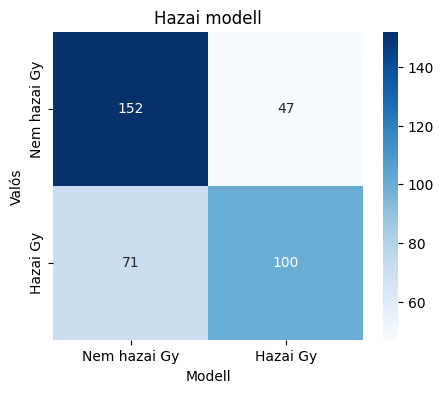

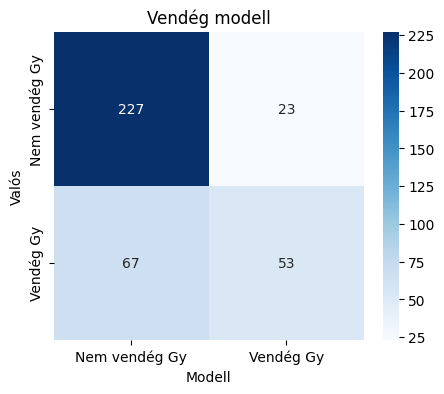

Legjobb küszöbérték a validációs halmazon: 0.12


In [238]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

test_predictions_pl, random_forest_home_pl, random_forest_away_pl = random_forest_final(premier_league,
                                                                                         drop_cols_home, drop_cols_away,
                                                                                         premier_league_params_home,premier_league_params_away)

In [241]:
def process_predictions(df):
    df = df.dropna()

    df.loc[:, 'odds_draw_model'] = 1 / df['prob_draw']
    df.loc[:, 'odds_away_win_model'] = 1 / df['prob_away_win']
    df.loc[:, 'odds_home_win_model'] = 1 / df['prob_home_win']

    df.loc[:, 'FTR'] = 0  
    df.loc[df['target_home_win'] == 1, 'FTR'] = 1  
    df.loc[df['target_away_win'] == 1, 'FTR'] = 2  

    df.loc[:, 'test_pred_numeric_hard'] = 0
    df.loc[df['test_pred_hard'] == "Home Win", 'test_pred_numeric_hard'] = 1  
    df.loc[df['test_pred_hard'] == "Away Win", 'test_pred_numeric_hard'] = 2 
    df.loc[df['test_pred_hard'] == "Draw", 'test_pred_numeric_hard'] = 0  

    df.loc[:, 'test_pred_numeric_soft'] = 0
    df.loc[df['test_pred_soft'] == "Home Win", 'test_pred_numeric_soft'] = 1  
    df.loc[df['test_pred_soft'] == "Away Win", 'test_pred_numeric_soft'] = 2 
    df.loc[df['test_pred_soft'] == "Draw", 'test_pred_numeric_soft'] = 0 

    selected_columns = [
        'target_home_win', 'target_away_win', 'target_draw', 'FTR',
        'test_pred_hard', 'test_pred_soft',
        'test_pred_numeric_hard', 'test_pred_numeric_soft'
    ]
    result_df = df[selected_columns]

    pred_odds = df[['FTR', 'test_pred_numeric_hard', 'test_pred_numeric_soft',
                    'HomeW_odds_market', 'odds_home_win_model',
                    'AwayW_odds_market', 'odds_away_win_model',
                    'Draw_odds_market', 'odds_draw_model']]

    return pred_odds

In [242]:
pred_odds_pl = process_predictions(test_predictions_pl)

In [438]:
def evaluation(pred_odds):
    print("Summary for HARD VOTING model")
    # cm_hard = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    # plt.figure(figsize=(4, 3))
    # sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Blues", 
    #             xticklabels=['X', 'Hazai GY', 'Idegen GY'], 
    #             yticklabels=['X', 'Hazai GY', 'Idegen GY'])
    # plt.xlabel("Model")
    # plt.ylabel("Valós")
    # plt.title("Konfúziós mx (Hard Voting)")
    # plt.show()
    accuracy_hard = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    report_hard = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"], digits=4)
    print("\nClassification Report (Hard Voting):\n", report_hard)

    # print("\nSummary for SOFT VOTING model")
    # cm_soft = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    # plt.figure(figsize=(4, 3))
    # sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Blues", 
    #             xticklabels=['X', 'Hazai GY', 'Idegen GY'], 
    #             yticklabels=['X', 'Hazai GY', 'Idegen GY'])
    # plt.xlabel("Model")
    # plt.ylabel("Valós")
    # plt.title("Konfúziós mx (Soft Voting)")
    # plt.show()
    accuracy_soft = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    report_soft = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"], digits=4)
    print("\nClassification Report (Soft Voting):\n", report_soft)

Summary for HARD VOTING model


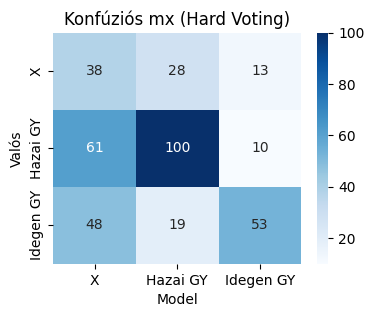


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.2585    0.4810    0.3363        79
           1     0.6803    0.5848    0.6289       171
           2     0.6974    0.4417    0.5408       120

    accuracy                         0.5162       370
   macro avg     0.5454    0.5025    0.5020       370
weighted avg     0.5958    0.5162    0.5379       370


Summary for SOFT VOTING model


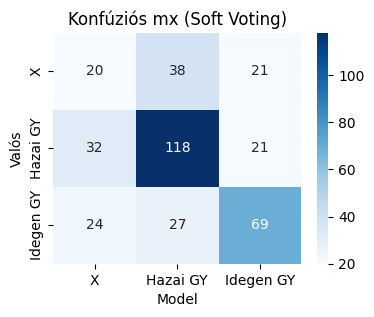


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.2632    0.2532    0.2581        79
           1     0.6448    0.6901    0.6667       171
           2     0.6216    0.5750    0.5974       120

    accuracy                         0.5595       370
   macro avg     0.5099    0.5061    0.5074       370
weighted avg     0.5558    0.5595    0.5570       370



In [244]:
evaluation(pred_odds_pl)

### fogadás

In [273]:
def betting_randomforest(df, stake):

    """
    Ezzel a fügvénnyel számolom ki a befektetés kamatát.
    Ezt külön megteszem a hard és a soft votingra.
    A tét fix, ezen lehet javítani valamilyen közgazdaságtanból származtatott optimalizálással.
    A profit definíciója a következő:
    
        (tét * historikus szorzó) - tét
    Felszummázzuk, majd a százalékos ROI-t a következőképpen kapjuk meg:
    
        (egyes meccsek profitjai felszummázva / összes elköltött pénz) * 100
    """
    df = df.copy() 

    df['Profit_hard'] = 0
    df['Profit_hard'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_hard'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_hard = df['Profit_hard'].sum()
    total_bets = len(df)

    roi_hard = (total_profit_hard / (total_bets * stake)) * 100
    
    print(f"ROI hard : {roi_hard:.2f}%")

    df['Profit_soft'] = 0
    df['Profit_soft'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_soft'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_soft = df['Profit_soft'].sum()
    total_bets = len(df)

    roi_soft = (total_profit_soft / (total_bets * stake)) * 100

    print(f"ROI soft : {roi_soft:.2f}%")

    df_profit_hard = df[df['FTR'] == df['test_pred_numeric_hard']]
    df_loss_hard = df[df['FTR'] != df['test_pred_numeric_hard']]
    
    df_profit_soft = df[df['FTR'] == df['test_pred_numeric_soft']]
    df_loss_soft = df[df['FTR'] != df['test_pred_numeric_soft']]

    return roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,df

In [274]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_pl,
                                                                                                                  stake=1)

ROI hard : 1.30%
ROI soft : 2.61%


Válassz(1 vagy 2):
1 - Hard votingos ROI
2 - Soft votingos ROI
 1


>0% profit 17 fordulóban


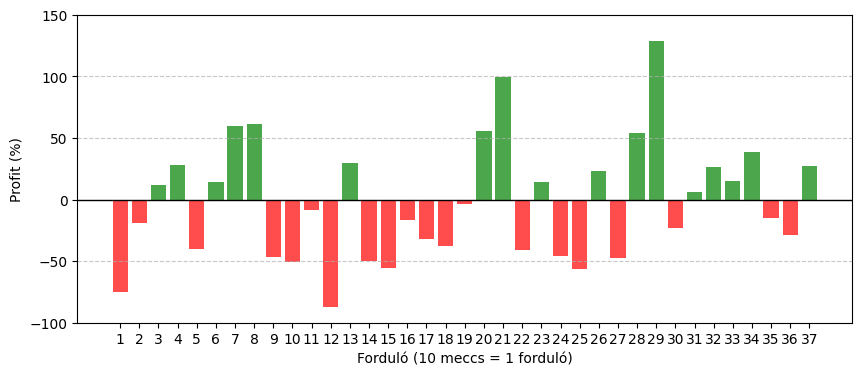

In [105]:
def ROI_sim_per_round(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    valasztas = input("Válassz(1 vagy 2):\n1 - Hard votingos ROI\n2 - Soft votingos ROI\n")
    if valasztas == "1":
        profit_column = "Profit_hard"
    elif valasztas == "2":
        profit_column = "Profit_soft"
    else:
        print("Csak 1 vagy 2 lehet az input")
        return
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({profit_column: 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round[profit_column] / (roi_per_round['Total_Bets'] * stake)) * 100

        
    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    # plt.title(f'Fogadási szimuláció, 2023-2024-es teszt szezon')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 150)  # Set y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # plt.savefig(r'abrak/PL_soft_ROI.jpg', format='jpg', dpi=300)
    plt.savefig(r'abrak/PL_hard_ROI.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_per_round(pred_odds_soft, round_size=10)

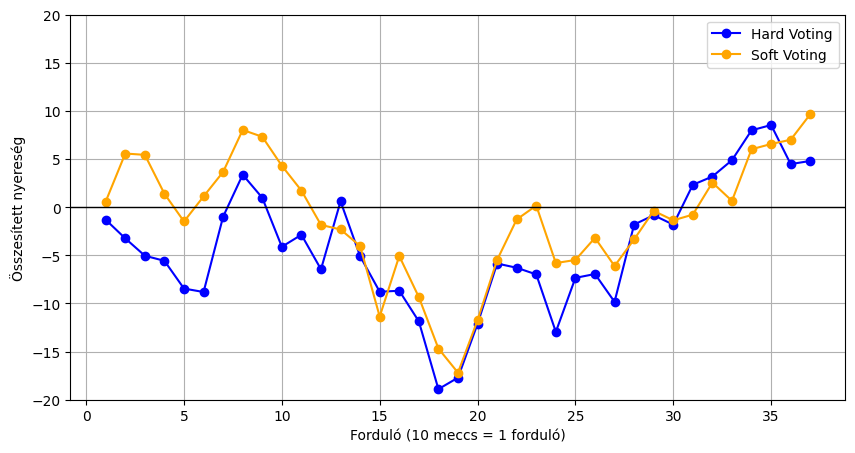

>0% profit 18 fordulóban (Hard Voting)
>0% profit 20 fordulóban (Soft Voting)


In [280]:
def stake_sim_per_round(df, stake=1, round_size=int):
    df = df.copy().reset_index(drop=True)

    df['Round'] = (df.index // round_size) + 1  
    roi_per_round_hard = df.groupby('Round').agg({'Profit_hard': 'sum'})
    roi_per_round_soft = df.groupby('Round').agg({'Profit_soft': 'sum'})
    
    roi_per_round_hard['Total_Bets'] = df.groupby('Round').size()
    roi_per_round_hard['ROI'] = (roi_per_round_hard['Profit_hard'] / (roi_per_round_hard['Total_Bets'] * stake)) * 100

    roi_per_round_hard['Cumulative_Profit'] = roi_per_round_hard['Profit_hard'].cumsum()
    roi_per_round_hard['Cumulative_Stake'] = roi_per_round_hard['Total_Bets'] * stake
    roi_per_round_hard['Total_Stake'] = roi_per_round_hard['Cumulative_Stake'] + stake  

    roi_per_round_soft['Total_Bets'] = df.groupby('Round').size()
    roi_per_round_soft['ROI'] = (roi_per_round_soft['Profit_soft'] / (roi_per_round_soft['Total_Bets'] * stake)) * 100

    roi_per_round_soft['Cumulative_Profit'] = roi_per_round_soft['Profit_soft'].cumsum()
    roi_per_round_soft['Cumulative_Stake'] = roi_per_round_soft['Total_Bets'] * stake
    roi_per_round_soft['Total_Stake'] = roi_per_round_soft['Cumulative_Stake'] + stake  

    plt.figure(figsize=(10, 5))
    plt.plot(roi_per_round_hard.index, roi_per_round_hard['Cumulative_Profit'], label='Hard Voting', color='blue', marker='o')
    plt.plot(roi_per_round_soft.index, roi_per_round_soft['Cumulative_Profit'], label='Soft Voting', color='orange', marker='o')

    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Összesített nyereség')
    plt.axhline(0, color='black', linewidth=1)
    plt.legend()
    plt.grid()
    plt.ylim(-20, 20) 
    plt.savefig(rf'abrak/PL_stake.jpg', format='jpg', dpi=300)
    plt.show()

    positive_rounds_hard = (roi_per_round_hard['ROI'] > 0).sum()
    positive_rounds_soft = (roi_per_round_soft['ROI'] > 0).sum()
    print(f'>0% profit {positive_rounds_hard} fordulóban (Hard Voting)')
    print(f'>0% profit {positive_rounds_soft} fordulóban (Soft Voting)')

stake_sim_per_round(pred_odds_soft, round_size=10)

## Bundesliga, full time result

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 45, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 3, 'n_estimators': 675})
accuracy: 0.6128

összegzés:
              precision    recall  f1-score   support

           0       0.61      0.76      0.67       156
           1       0.63      0.45      0.53       141

    accuracy                           0.61       297
   macro avg       0.62      0.61      0.60       297
weighted avg       0.62      0.61      0.60       297



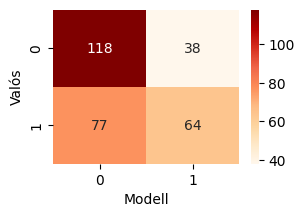


top15 valtozo:
                       feature  importance
54      prob_AwayW_odds_market    0.087415
53      prob_HomeW_odds_market    0.086866
52                     GD_diff    0.041945
51      cumulative_points_diff    0.036036
6      home_expected_points_RA    0.031175
13  home_cumulative_goals_diff    0.028922
9     home_np_xg_difference_RA    0.028610
30               away_np_xg_RA    0.028127
55       prob_Draw_odds_market    0.027970
31    away_np_xg_difference_RA    0.026740
11    home_deep_completions_RA    0.025939
7                   home_xg_RA    0.025220
28     away_expected_points_RA    0.024734
2                home_shots_RA    0.023660
35  away_cumulative_goals_diff    0.022968


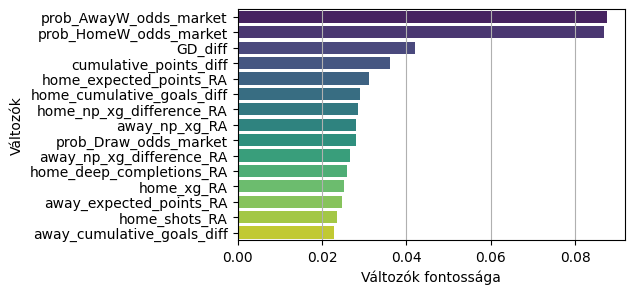

In [283]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

bundesliga_tuned_home, bundesliga_params_home, bundesliga_top_features_home = random_forest_tuning(
    bundesliga,
    target_col,
    drop)

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 747})
accuracy: 0.7273

összegzés:
              precision    recall  f1-score   support

           0       0.74      0.95      0.83       214
           1       0.54      0.16      0.24        83

    accuracy                           0.73       297
   macro avg       0.64      0.55      0.54       297
weighted avg       0.69      0.73      0.67       297



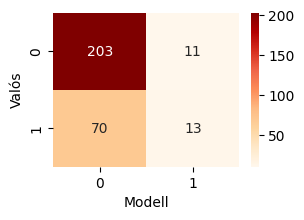


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.077359
54      prob_AwayW_odds_market    0.070891
52                     GD_diff    0.038651
31    away_np_xg_difference_RA    0.033562
51      cumulative_points_diff    0.031590
55       prob_Draw_odds_market    0.030734
9     home_np_xg_difference_RA    0.027102
35  away_cumulative_goals_diff    0.027081
13  home_cumulative_goals_diff    0.025783
28     away_expected_points_RA    0.025727
6      home_expected_points_RA    0.024590
33    away_deep_completions_RA    0.024067
8                home_np_xg_RA    0.024023
30               away_np_xg_RA    0.023609
7                   home_xg_RA    0.023083


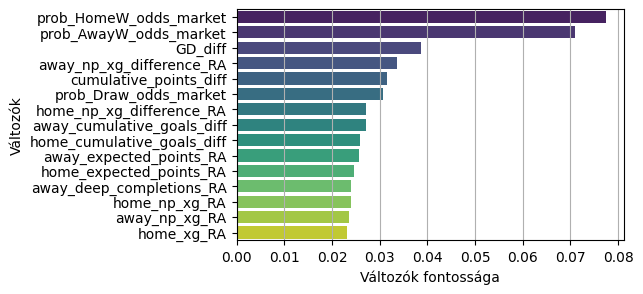

In [284]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

bundesliga_tuned_away, bundesliga_params_away, bundesliga_top_features_away = random_forest_tuning(
    bundesliga,
    target_col,
    drop)

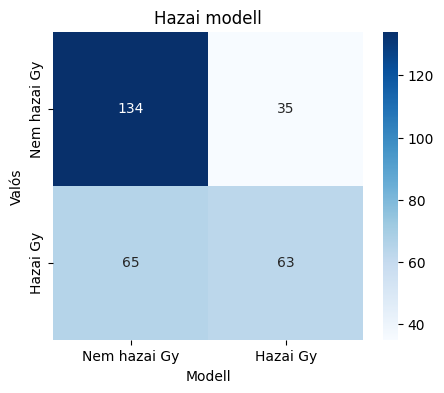

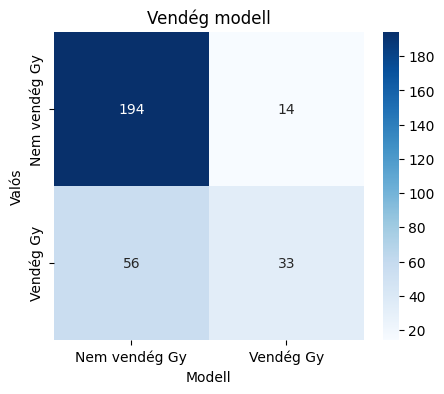

Legjobb küszöbérték a validációs halmazon: 0.09


In [285]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_bundesliga, random_forest_home_bundesliga, random_forest_away_bundesliga = random_forest_final(
    bundesliga,
    drop_cols_home,
    drop_cols_away,
    bundesliga_params_home,
    bundesliga_params_away
)

In [286]:
pred_odds_bundesliga = process_predictions(test_predictions_bundesliga)

Summary for HARD VOTING model


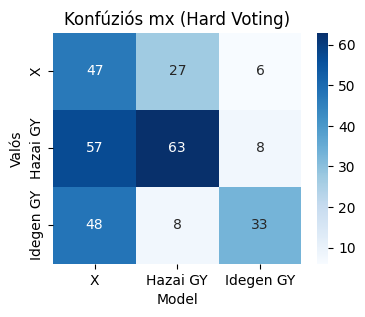


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.3092    0.5875    0.4052        80
           1     0.6429    0.4922    0.5575       128
           2     0.7021    0.3708    0.4853        89

    accuracy                         0.4815       297
   macro avg     0.5514    0.4835    0.4827       297
weighted avg     0.5707    0.4815    0.4948       297


Summary for SOFT VOTING model


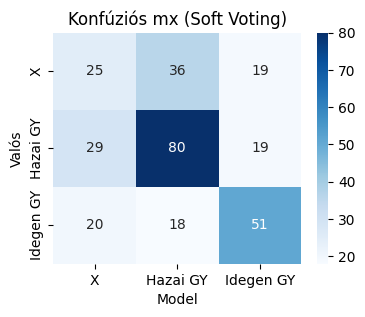


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3378    0.3125    0.3247        80
           1     0.5970    0.6250    0.6107       128
           2     0.5730    0.5730    0.5730        89

    accuracy                         0.5253       297
   macro avg     0.5026    0.5035    0.5028       297
weighted avg     0.5200    0.5253    0.5224       297



In [287]:
evaluation(pred_odds_bundesliga)

In [288]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_bundesliga,
                                                                                                                  stake=500)

ROI hard : 5.76%
ROI soft : 4.26%


Válassz(1 vagy 2):
1 - Hard votingos ROI
2 - Soft votingos ROI
 1


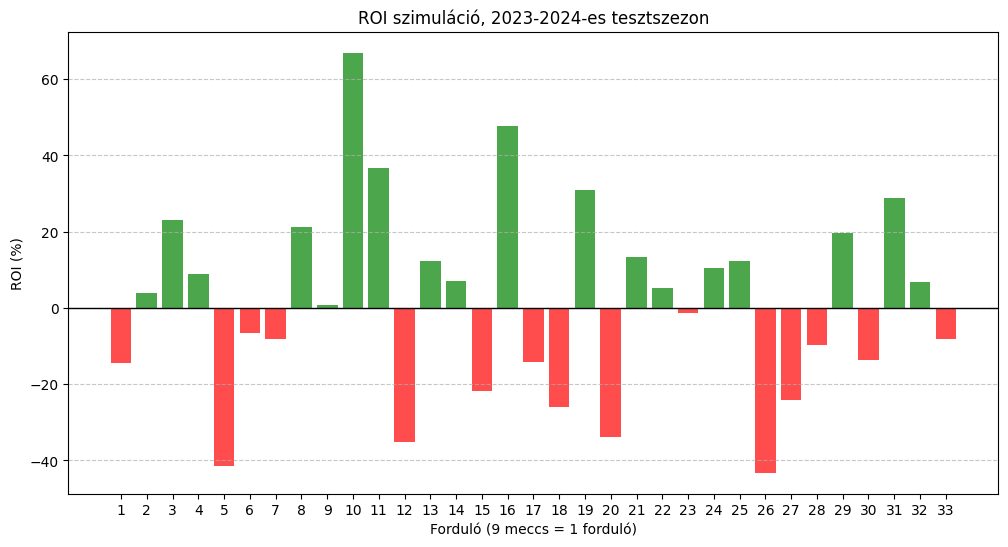

In [55]:
ROI_sim_per_round(pred_odds_soft, round_size=9)

## Serie A, full time result

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 23, 'max_features': 'sqrt', 'min_samples_leaf': 13, 'min_samples_split': 5, 'n_estimators': 1000})
accuracy: 0.6397

összegzés:
              precision    recall  f1-score   support

           0       0.66      0.76      0.71       205
           1       0.60      0.48      0.53       153

    accuracy                           0.64       358
   macro avg       0.63      0.62      0.62       358
weighted avg       0.63      0.64      0.63       358



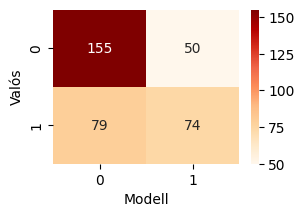


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.118744
54      prob_AwayW_odds_market    0.107191
52                     GD_diff    0.044592
55       prob_Draw_odds_market    0.043890
51      cumulative_points_diff    0.040183
28     away_expected_points_RA    0.028011
31    away_np_xg_difference_RA    0.027776
9     home_np_xg_difference_RA    0.025799
6      home_expected_points_RA    0.024054
13  home_cumulative_goals_diff    0.022859
35  away_cumulative_goals_diff    0.020989
10                home_ppda_RA    0.019914
29                  away_xg_RA    0.019680
7                   home_xg_RA    0.019280
32                away_ppda_RA    0.019259


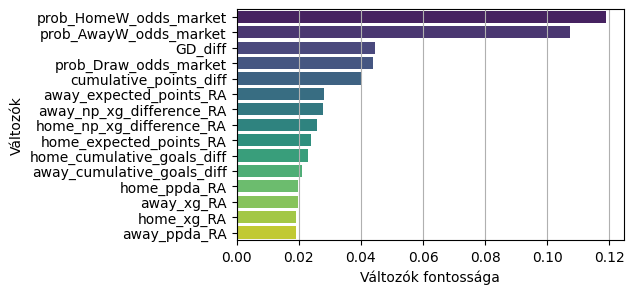

In [312]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

serie_a_tuned_home, serie_a_params_home, serie_a_top_features_home = random_forest_tuning(serie_a,
                                                                                          target_col,
                                                                                          drop)

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 730})
accuracy: 0.7179

összegzés:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       245
           1       0.57      0.41      0.48       113

    accuracy                           0.72       358
   macro avg       0.67      0.63      0.64       358
weighted avg       0.70      0.72      0.70       358



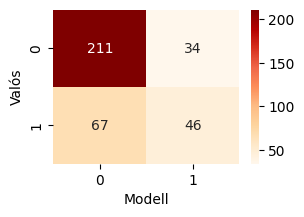


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.091952
54      prob_AwayW_odds_market    0.081797
52                     GD_diff    0.041303
51      cumulative_points_diff    0.034606
31    away_np_xg_difference_RA    0.028326
55       prob_Draw_odds_market    0.027706
35  away_cumulative_goals_diff    0.026206
28     away_expected_points_RA    0.025469
10                home_ppda_RA    0.023557
33    away_deep_completions_RA    0.023542
13  home_cumulative_goals_diff    0.023025
30               away_np_xg_RA    0.022991
9     home_np_xg_difference_RA    0.022918
32                away_ppda_RA    0.022139
6      home_expected_points_RA    0.022092


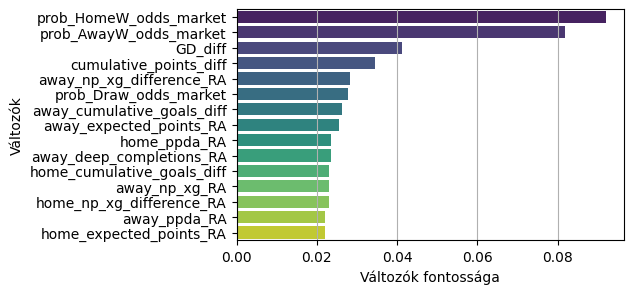

In [313]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

serie_a_tuned_away, serie_a_params_away, serie_a_top_features_away = random_forest_tuning(serie_a,
                                                                                          target_col,
                                                                                          drop)

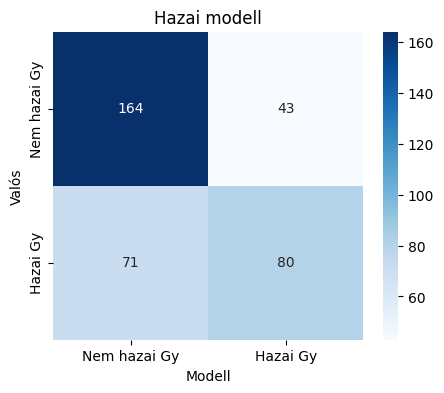

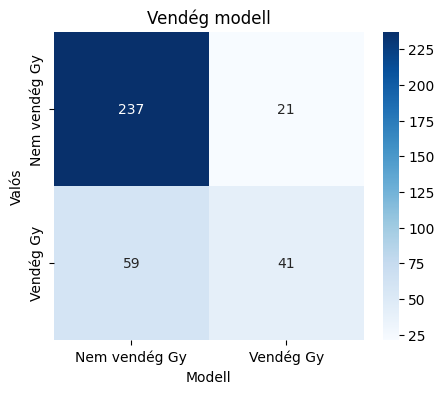

Legjobb küszöbérték a validációs halmazon: 0.21


In [314]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_serie_a, random_forest_home_serie_a, random_forest_away_serie_a = random_forest_final(
    serie_a,
    drop_cols_home,
    drop_cols_away,
    serie_a_params_home,
    serie_a_params_away
)

In [317]:
pred_odds_serie_a = process_predictions(test_predictions_serie_a)

Summary for HARD VOTING model


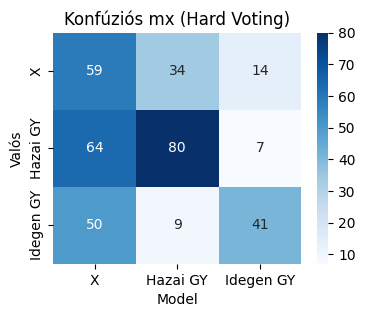


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.3410    0.5514    0.4214       107
           1     0.6504    0.5298    0.5839       151
           2     0.6613    0.4100    0.5062       100

    accuracy                         0.5028       358
   macro avg     0.5509    0.4971    0.5038       358
weighted avg     0.5610    0.5028    0.5136       358


Summary for SOFT VOTING model


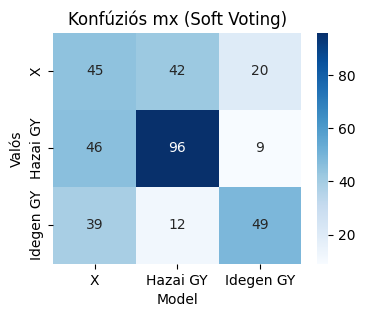


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3462    0.4206    0.3797       107
           1     0.6400    0.6358    0.6379       151
           2     0.6282    0.4900    0.5506       100

    accuracy                         0.5307       358
   macro avg     0.5381    0.5154    0.5227       358
weighted avg     0.5489    0.5307    0.5363       358



In [318]:
evaluation(pred_odds_serie_a)

In [319]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_serie_a,
                                                                                                                  stake=500)

ROI hard : 9.43%
ROI soft : 10.21%


In [63]:
# ROI_sim_per_round(pred_odds_soft, round_size=10)

## Ligue 1, full time result

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 17, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 8, 'n_estimators': 1000})
accuracy: 0.6847

összegzés:
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       205
           1       0.63      0.60      0.61       147

    accuracy                           0.68       352
   macro avg       0.68      0.67      0.67       352
weighted avg       0.68      0.68      0.68       352



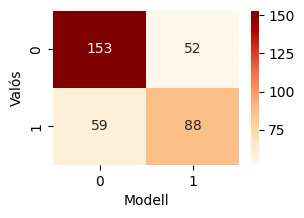


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.092823
54      prob_AwayW_odds_market    0.081728
52                     GD_diff    0.042685
51      cumulative_points_diff    0.037821
55       prob_Draw_odds_market    0.034630
31    away_np_xg_difference_RA    0.030880
7                   home_xg_RA    0.027432
8                home_np_xg_RA    0.027270
35  away_cumulative_goals_diff    0.026192
9     home_np_xg_difference_RA    0.026106
28     away_expected_points_RA    0.025812
57       prob_O2.5_odds_market    0.025395
6      home_expected_points_RA    0.024932
10                home_ppda_RA    0.024490
13  home_cumulative_goals_diff    0.023867


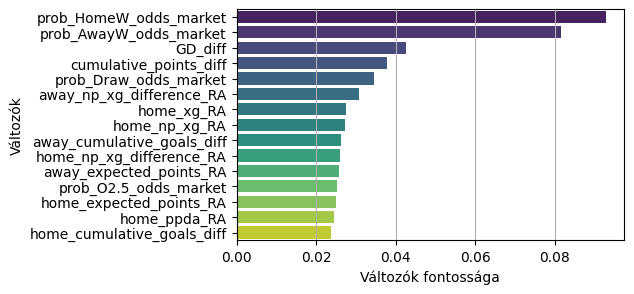

In [321]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

ligue_1_tuned_home, ligue_1_params_home, ligue_1_top_features_home = random_forest_tuning(
    ligue_1,
    target_col,
    drop
)


tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 100})
accuracy: 0.6818

összegzés:
              precision    recall  f1-score   support

           0       0.70      0.90      0.79       233
           1       0.56      0.26      0.36       119

    accuracy                           0.68       352
   macro avg       0.63      0.58      0.57       352
weighted avg       0.66      0.68      0.64       352



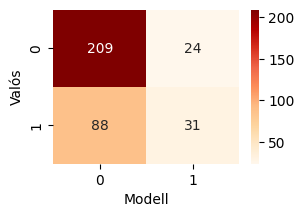


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.063533
54      prob_AwayW_odds_market    0.063009
52                     GD_diff    0.035263
51      cumulative_points_diff    0.031510
35  away_cumulative_goals_diff    0.028877
28     away_expected_points_RA    0.028612
9     home_np_xg_difference_RA    0.027810
31    away_np_xg_difference_RA    0.027541
10                home_ppda_RA    0.027094
55       prob_Draw_odds_market    0.026786
8                home_np_xg_RA    0.024896
32                away_ppda_RA    0.024523
44            home_clinicality    0.024374
11    home_deep_completions_RA    0.023282
29                  away_xg_RA    0.023265


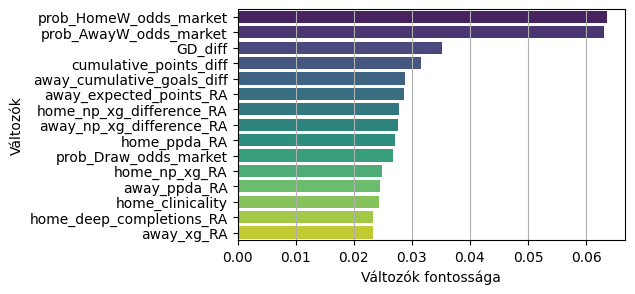

In [322]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

ligue_1_tuned_away, ligue_1_params_away, ligue_1_top_features_away = random_forest_tuning(
    ligue_1,
    target_col,
    drop
)


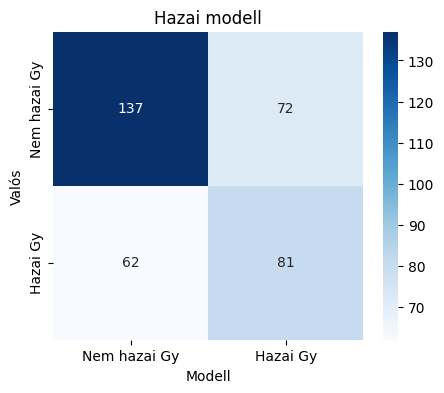

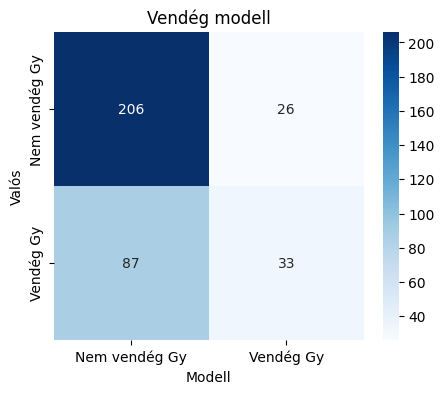

Legjobb küszöbérték a validációs halmazon: 0.16


In [323]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_ligue_1, random_forest_home_ligue_1, random_forest_away_ligue_1 = random_forest_final(
    ligue_1,
    drop_cols_home,
    drop_cols_away,
    ligue_1_params_home,
    ligue_1_params_away
)

In [324]:
pred_odds_ligue1 = process_predictions(test_predictions_ligue_1)

Summary for HARD VOTING model


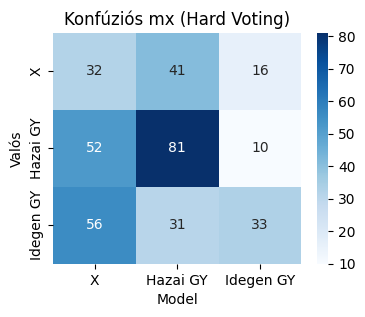


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.2286    0.3596    0.2795        89
           1     0.5294    0.5664    0.5473       143
           2     0.5593    0.2750    0.3687       120

    accuracy                         0.4148       352
   macro avg     0.4391    0.4003    0.3985       352
weighted avg     0.4635    0.4148    0.4187       352


Summary for SOFT VOTING model


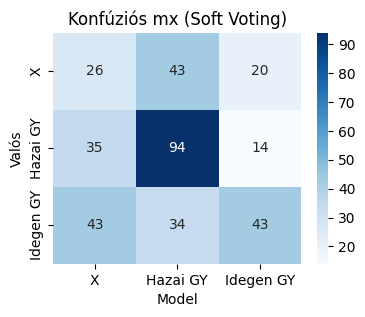


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.2500    0.2921    0.2694        89
           1     0.5497    0.6573    0.5987       143
           2     0.5584    0.3583    0.4365       120

    accuracy                         0.4631       352
   macro avg     0.4527    0.4359    0.4349       352
weighted avg     0.4769    0.4631    0.4602       352



In [325]:
evaluation(pred_odds_ligue1)

In [327]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_ligue1,
                                                                                                                  stake=1)

ROI hard : -14.82%
ROI soft : -6.72%


In [70]:
# ROI_sim_per_round(pred_odds_soft, round_size=10)

## La Liga, full time result

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 41, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 15, 'n_estimators': 1000})
accuracy: 0.6189

összegzés:
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       191
           1       0.64      0.49      0.56       179

    accuracy                           0.62       370
   macro avg       0.62      0.61      0.61       370
weighted avg       0.62      0.62      0.61       370



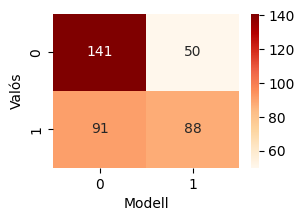


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.136619
54      prob_AwayW_odds_market    0.126132
52                     GD_diff    0.055959
51      cumulative_points_diff    0.045347
55       prob_Draw_odds_market    0.044259
35  away_cumulative_goals_diff    0.029847
13  home_cumulative_goals_diff    0.029148
6      home_expected_points_RA    0.023933
31    away_np_xg_difference_RA    0.023820
9     home_np_xg_difference_RA    0.023518
28     away_expected_points_RA    0.022312
33    away_deep_completions_RA    0.022051
30               away_np_xg_RA    0.021302
11    home_deep_completions_RA    0.020444
8                home_np_xg_RA    0.020134


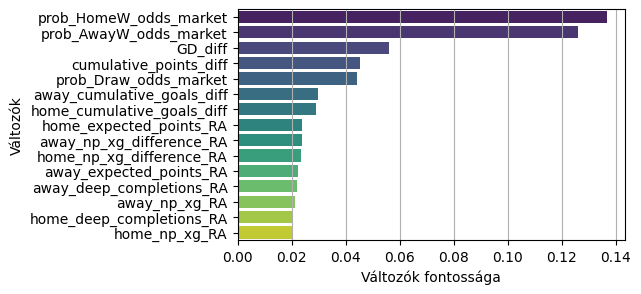

In [328]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

la_liga_tuned_home, la_liga_params_home, la_liga_top_features_home = random_forest_tuning(
    la_liga,
    target_col,
    drop
)

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100})
accuracy: 0.7351

összegzés:
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       265
           1       0.58      0.25      0.35       105

    accuracy                           0.74       370
   macro avg       0.67      0.59      0.59       370
weighted avg       0.71      0.74      0.70       370



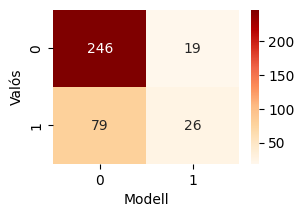


top15 valtozo:
                       feature  importance
53      prob_HomeW_odds_market    0.056170
54      prob_AwayW_odds_market    0.053291
52                     GD_diff    0.036441
51      cumulative_points_diff    0.027952
55       prob_Draw_odds_market    0.027427
30               away_np_xg_RA    0.026474
35  away_cumulative_goals_diff    0.025742
29                  away_xg_RA    0.025714
31    away_np_xg_difference_RA    0.024764
28     away_expected_points_RA    0.024301
33    away_deep_completions_RA    0.023977
9     home_np_xg_difference_RA    0.023937
32                away_ppda_RA    0.023852
10                home_ppda_RA    0.023312
6      home_expected_points_RA    0.023211


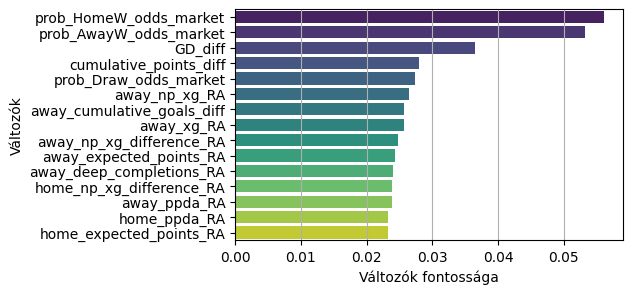

In [329]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

la_liga_tuned_away, la_liga_params_away, la_liga_top_features_away = random_forest_tuning(
    la_liga,
    target_col,
    drop
)


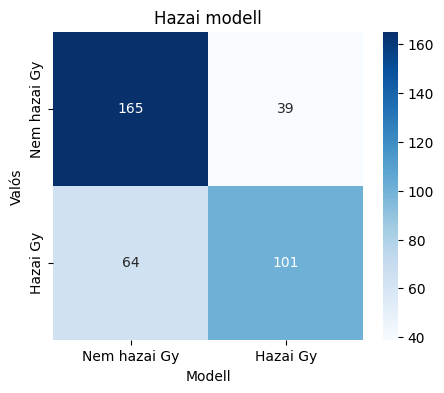

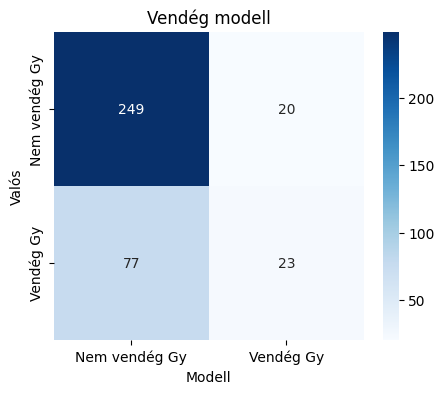

Legjobb küszöbérték a validációs halmazon: 0.12


In [330]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_la_liga, random_forest_home_la_liga, random_forest_away_la_liga = random_forest_final(
    la_liga,
    drop_cols_home,
    drop_cols_away,
    la_liga_params_home,
    la_liga_params_away
)

In [331]:
pred_odds_laliga = process_predictions(test_predictions_la_liga)

Summary for HARD VOTING model


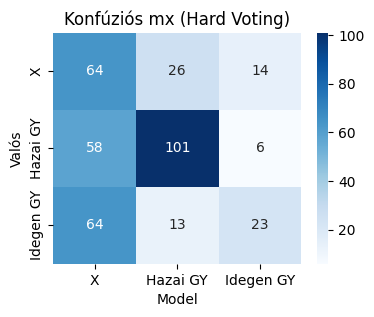


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.3441    0.6154    0.4414       104
           1     0.7214    0.6121    0.6623       165
           2     0.5349    0.2300    0.3217       100

    accuracy                         0.5095       369
   macro avg     0.5335    0.4858    0.4751       369
weighted avg     0.5645    0.5095    0.5077       369


Summary for SOFT VOTING model


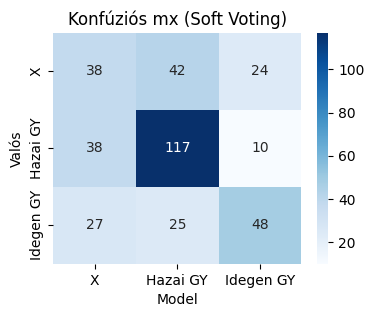


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3689    0.3654    0.3671       104
           1     0.6359    0.7091    0.6705       165
           2     0.5854    0.4800    0.5275       100

    accuracy                         0.5501       369
   macro avg     0.5301    0.5182    0.5217       369
weighted avg     0.5469    0.5501    0.5462       369



In [332]:
evaluation(pred_odds_laliga)

In [334]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_laliga,
                                                                                                                  stake=500)

ROI hard : 12.41%
ROI soft : 12.28%


In [138]:
# ROI_sim_per_round(pred_odds_soft, round_size=10)

## big5 combined, full time result

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 27, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 13, 'n_estimators': 108})
accuracy: 0.6546

összegzés:
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       949
           1       0.66      0.51      0.57       797

    accuracy                           0.65      1746
   macro avg       0.66      0.64      0.64      1746
weighted avg       0.66      0.65      0.65      1746



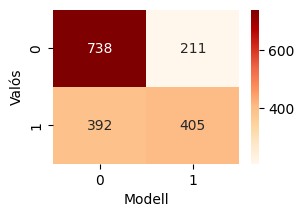


top15 valtozo:
                     feature  importance
53    prob_HomeW_odds_market    0.065770
54    prob_AwayW_odds_market    0.065604
52                   GD_diff    0.036584
55     prob_Draw_odds_market    0.034712
51    cumulative_points_diff    0.031423
6    home_expected_points_RA    0.028292
31  away_np_xg_difference_RA    0.027722
9   home_np_xg_difference_RA    0.025971
28   away_expected_points_RA    0.025067
29                away_xg_RA    0.024881
30             away_np_xg_RA    0.024822
10              home_ppda_RA    0.024478
8              home_np_xg_RA    0.024315
7                 home_xg_RA    0.024099
32              away_ppda_RA    0.023612


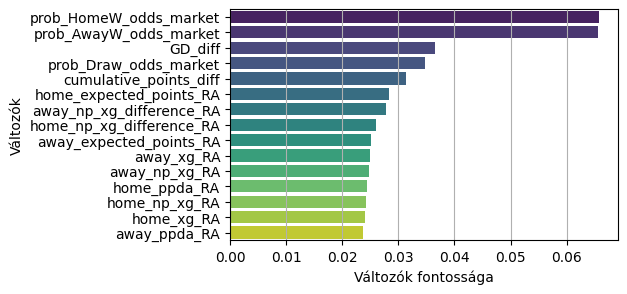

In [335]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


big5_tuned_home, big5_params_home, big5_top_features_home = random_forest_tuning(
    big5,
    target_col,
    drop
)

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)

legjobb modell hiperparameterei: OrderedDict({'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 100})
accuracy: 0.7159

összegzés:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1222
           1       0.55      0.28      0.37       524

    accuracy                           0.72      1746
   macro avg       0.65      0.59      0.59      1746
weighted avg       0.69      0.72      0.68      1746



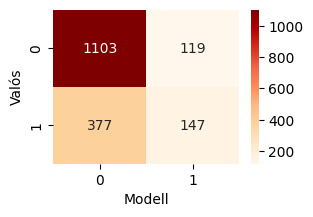


top15 valtozo:
                     feature  importance
53    prob_HomeW_odds_market    0.072567
54    prob_AwayW_odds_market    0.066589
52                   GD_diff    0.033608
55     prob_Draw_odds_market    0.030962
51    cumulative_points_diff    0.030956
31  away_np_xg_difference_RA    0.029206
9   home_np_xg_difference_RA    0.028411
28   away_expected_points_RA    0.028112
30             away_np_xg_RA    0.024776
45          away_clinicality    0.024625
10              home_ppda_RA    0.024624
32              away_ppda_RA    0.024487
6    home_expected_points_RA    0.024398
44          home_clinicality    0.024172
29                away_xg_RA    0.024149


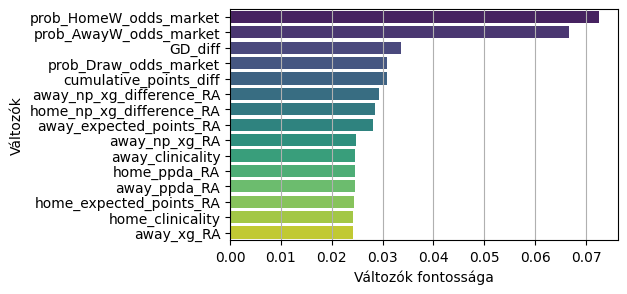

In [336]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

big5_tuned_away, big5_params_away, big5_top_features_away = random_forest_tuning(
    big5,
    target_col,
    drop
)

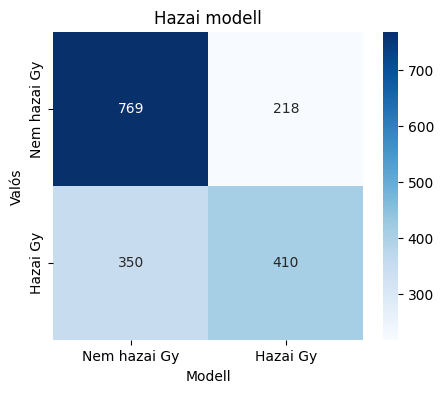

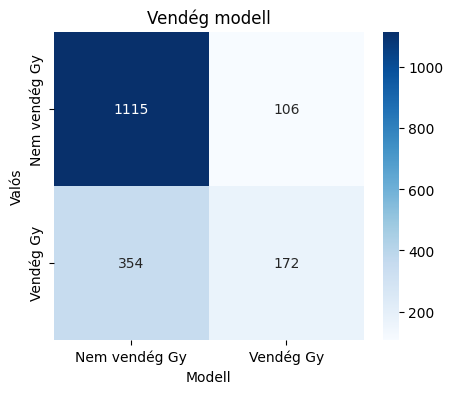

Legjobb küszöbérték a validációs halmazon: 0.14


In [337]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']


test_predictions_big5, random_forest_home_big5, random_forest_away_big5 = random_forest_final(
    big5,
    drop_cols_home,
    drop_cols_away,
    big5_params_home,
    big5_params_away
)

In [338]:
pred_odds_big5 = process_predictions(test_predictions_big5)

Summary for HARD VOTING model


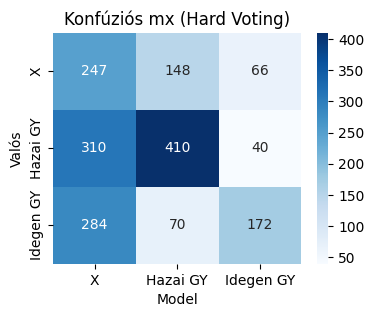


Classification Report (Hard Voting):
               precision    recall  f1-score   support

           0     0.2937    0.5358    0.3794       461
           1     0.6529    0.5395    0.5908       760
           2     0.6187    0.3270    0.4279       526

    accuracy                         0.4745      1747
   macro avg     0.5218    0.4674    0.4660      1747
weighted avg     0.5478    0.4745    0.4860      1747


Summary for SOFT VOTING model


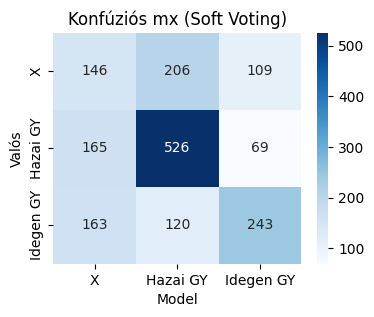


Classification Report (Soft Voting):
               precision    recall  f1-score   support

           0     0.3080    0.3167    0.3123       461
           1     0.6174    0.6921    0.6526       760
           2     0.5772    0.4620    0.5132       526

    accuracy                         0.5238      1747
   macro avg     0.5009    0.4903    0.4927      1747
weighted avg     0.5236    0.5238    0.5208      1747



In [339]:
evaluation(pred_odds_big5)

In [340]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_randomforest(pred_odds_big5,
                                                                                                                  stake=500)

ROI hard : 1.56%
ROI soft : 3.20%


In [ ]:
# ROI_sim_per_round(pred_odds_soft, round_size=48)

# Under/Over 2.5 

## PL

In [342]:
def random_forest_tuning_underover(df, target_col, drop_cols=[]):
    
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]

    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))

    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 

    print(f"tanító halmaz dimenziók: {train_set.shape}")
    print(f"validációs halmaz dimenziók: {val_set.shape}")
        
    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    param_space = {
        'n_estimators': Integer(100, 1000),
        'max_depth': Integer(10, 50),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20),
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None]  
    }
    
    rf = RandomForestClassifier(random_state=1)
    
    bayes_search = BayesSearchCV(
        estimator=rf,
        search_spaces=param_space,
        n_iter=30,  
        scoring='f1',
        refit='f1',
        cv=TimeSeriesSplit(n_splits=5),  
        verbose=0,
        n_jobs=-1,  
        random_state=1
    )

    bayes_search.fit(X_train, y_train)  

    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    print("\nlegjobb modell hiperparameterei:", best_params)

    y_val_probs = best_model.predict_proba(X_val)
    val_set = val_set.copy()
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  

    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []
    
    for t in thresholds:
        preds = (y_val_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_val, preds, average='macro'))
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    print(f"\n legjobb threshold: {best_threshold:.2f}, legjobb F1: {best_f1:.4f}")
    
    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.2f}')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.show()

    y_pred = (y_val_probs[:, 1] >= best_threshold).astype(int)
    val_set['Predicted'] = y_pred

    accuracy = accuracy_score(y_val, y_pred)
    print(f"accuracy: {accuracy:.4f}")
    print(classification_report(y_val, y_pred))

    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()

    feature_importances = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    print("\ntop15 valtozo:")
    top_features = feature_importances.head(15)
    print(top_features)
    
    plt.figure(figsize=(5, 3))
    sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
    plt.xlabel("Változók fontossága")
    plt.ylabel("Változók")
    plt.grid(axis='x')
    plt.show()

    return val_set, best_params, top_features

In [349]:
# def random_forest_tuning_underover(df, target_col, drop_cols=[]):
    
#     df = df.dropna().reset_index(drop=True)

#     train_n = int(round(len(df) * 0.8, 0)) 
#     val_n = int(round(len(df) * 0.10, 0))   
    
#     train_set = df.iloc[:train_n].copy()        
#     val_set = df.iloc[train_n:train_n + val_n].copy()
#     test_set = df.iloc[train_n + val_n:].copy() 
    
#     print(f"tanító halmaz dimenziók: {train_set.shape}")
#     print(f"validációs halmaz dimenziók: {val_set.shape}")
#     print(f"teszt halmaz dimenziók: {test_set.shape}")
        
#     print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
#     print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")
#     print(f"teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")
    
#     X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
#     X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]
#     X_test, y_test = test_set.drop(columns=[target_col] + drop_cols), test_set[target_col]
    
#     param_space = {
#         'n_estimators': Integer(100, 1000),
#         'max_depth': Integer(10, 50),
#         'min_samples_split': Integer(2, 20),
#         'min_samples_leaf': Integer(1, 20),
#         'criterion': ['gini', 'entropy'],
#         'max_features': ['sqrt', 'log2'],
#         'class_weight': ['balanced', None]  
#     }
    
#     rf = RandomForestClassifier(random_state=1)
    
#     bayes_search = BayesSearchCV(
#         estimator=rf,
#         search_spaces=param_space,
#         n_iter=30,  
#         scoring='f1',
#         refit='f1',
#         cv=TimeSeriesSplit(n_splits=5),  
#         verbose=0,
#         n_jobs=-1,  
#         random_state=1
#     )
    
#     bayes_search.fit(X_train, y_train)  
#     best_model = bayes_search.best_estimator_
#     best_params = bayes_search.best_params_
#     print("\nlegjobb modell hiperparameterei:", best_params)
    
#     # Küszöbérték optimalizálás a validation adaton
#     y_val_probs = best_model.predict_proba(X_val)
#     val_set['P_0'] = y_val_probs[:, 0] 
#     val_set['P_1'] = y_val_probs[:, 1]  
    
#     thresholds = np.arange(0.4, 0.6, 0.01)
#     f1_scores = []
    
#     for t in thresholds:
#         preds = (y_val_probs[:, 1] >= t).astype(int)
#         f1_scores.append(f1_score(y_val, preds, average='macro'))
    
#     best_threshold = thresholds[np.argmax(f1_scores)]
#     best_f1 = max(f1_scores)
    
#     print(f"\n legjobb threshold: {best_threshold:.2f}, legjobb F1: {best_f1:.4f}")
    
#     plt.figure(figsize=(7, 4))
#     plt.plot(thresholds, f1_scores, color='teal')
#     plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.2f}')
#     plt.xlabel("Határérték")
#     plt.ylabel("Átlagos F1-érték")
#     plt.grid()
#     plt.legend()
#     plt.show()
    
#     # val set kiértékelése
#     y_pred_val = (y_val_probs[:, 1] >= best_threshold).astype(int)
#     val_set['Predicted'] = y_pred_val
#     accuracy_val = accuracy_score(y_val, y_pred_val)
#     print(f"Validation accuracy: {accuracy_val:.4f}")
#     print("val eredmények:")
#     print(classification_report(y_val, y_pred_val))
    
#     plt.figure(figsize=(3, 2))
#     cm_val = confusion_matrix(y_val, y_pred_val)
#     sns.heatmap(cm_val, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
#     plt.xlabel("Modell")
#     plt.ylabel("Valós")
#     plt.title("Validation")
#     plt.show()
    
#     # teszt set kiértékelése 
#     y_test_probs = best_model.predict_proba(X_test)
#     y_pred_test = (y_test_probs[:, 1] >= best_threshold).astype(int)
#     test_set['P_0'] = y_test_probs[:, 0]
#     test_set['P_1'] = y_test_probs[:, 1]
#     test_set['Predicted'] = y_pred_test
    
#     accuracy_test = accuracy_score(y_test, y_pred_test)
#     print(f"\ntest accuracy: {accuracy_test:.4f}")
#     print("test eredmények:")
#     print(classification_report(y_test, y_pred_test))
    
#     plt.figure(figsize=(3, 2))
#     cm_test = confusion_matrix(y_test, y_pred_test)
#     sns.heatmap(cm_test, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
#     plt.xlabel("Modell")
#     plt.ylabel("Valós")
#     plt.title("Test")
#     plt.show()
    
#     feature_importances = pd.DataFrame({
#         'feature': X_train.columns,
#         'importance': best_model.feature_importances_
#     }).sort_values(by='importance', ascending=False)
    
#     print("\ntop15 valtozo:")
#     top_features = feature_importances.head(15)
#     print(top_features)
    
#     plt.figure(figsize=(5, 3))
#     sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
#     plt.xlabel("Változók fontossága")
#     plt.ylabel("Változók")
#     plt.grid(axis='x')
#     plt.show()
    
#     return val_set, test_set, top_features, best_model

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)
teszt halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
teszt halmaz:  (i: 3329 -> 3698)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 16, 'min_samples_split': 20, 'n_estimators': 1000})

 legjobb threshold: 0.56, legjobb F1: 0.5584


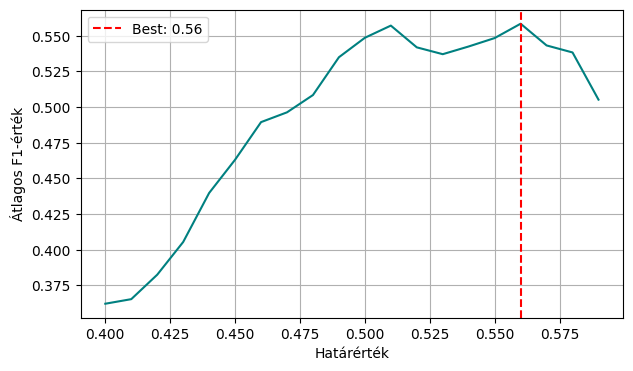

Validation accuracy: 0.5622
val eredmények:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60       175
           1       0.62      0.45      0.52       195

    accuracy                           0.56       370
   macro avg       0.57      0.57      0.56       370
weighted avg       0.58      0.56      0.56       370



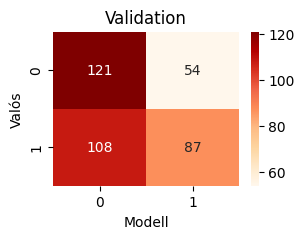


test accuracy: 0.5297
test eredmények:
              precision    recall  f1-score   support

           0       0.34      0.36      0.35       129
           1       0.64      0.62      0.63       241

    accuracy                           0.53       370
   macro avg       0.49      0.49      0.49       370
weighted avg       0.54      0.53      0.53       370



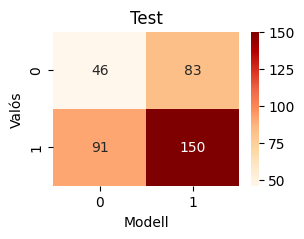


top15 valtozo:
                     feature  importance
57     prob_O2.5_odds_market    0.046499
56     prob_U2.5_odds_market    0.045717
55     prob_Draw_odds_market    0.038093
32              away_ppda_RA    0.033251
24             away_shots_RA    0.032669
45          away_clinicality    0.030862
33  away_deep_completions_RA    0.029380
44          home_clinicality    0.027241
7                 home_xg_RA    0.026988
53    prob_HomeW_odds_market    0.026952
10              home_ppda_RA    0.026423
6    home_expected_points_RA    0.026149
54    prob_AwayW_odds_market    0.026016
9   home_np_xg_difference_RA    0.025858
29                away_xg_RA    0.025718


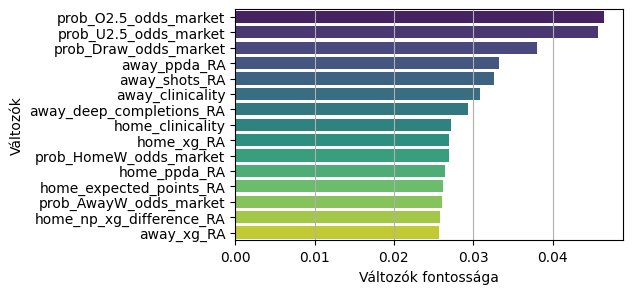

In [350]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
#        'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_U2.5_odds_market','prob_O2.5_odds_market']


premier_league_tuning_underover, premier_league_test_underover, premier_league_topfeatures_underover = random_forest_tuning_underover(
    premier_league,
    target_col,
    drop)

In [517]:
def random_forest_test_underover(df, target_col, drop_cols=[], best_params={}):
    
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.9, 0))
    test_n = len(df) - train_n 

    train_set = df.iloc[:train_n]        
    test_set = df.iloc[train_n:] 

    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_test, y_test = test_set.drop(columns=[target_col] + drop_cols), test_set[target_col]
                
    rf = RandomForestClassifier(
        n_estimators=best_params.get('n_estimators', 500),
        max_depth=best_params.get('max_depth', 10),
        min_samples_split=best_params.get('min_samples_split', 2),
        min_samples_leaf=best_params.get('min_samples_leaf', 1),
        criterion=best_params.get('criterion', 'entropy'),
        max_features=best_params.get('max_features', 'sqrt'),
        random_state=best_params.get('random_state', 1),
        class_weight=best_params.get('class_weight', None)
    )
    
    rf.fit(X_train, y_train)

    y_test_probs = rf.predict_proba(X_test)
    
    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []

    for t in thresholds:
        preds = (y_test_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_test, preds, average='macro'))

    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)

    print(f"\n legjobb threshold: {best_threshold:.2f}, legjobb F1: {best_f1:.4f}")

    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best: {best_threshold:.2f}')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.show()

    y_pred = (y_test_probs[:, 1] >= best_threshold).astype(int)

    test_set = test_set.copy()
    test_set['P_0'] = y_test_probs[:, 0]
    test_set['P_1'] = y_test_probs[:, 1]
    test_set['Predicted'] = y_pred

    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(3, 2))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.show()

    return test_set, rf



tanító halmaz indexek: (i: 1 -> 3328)
teszt halmaz:  (i: 3329 -> 3698)

 legjobb threshold: 0.57, legjobb F1: 0.5253


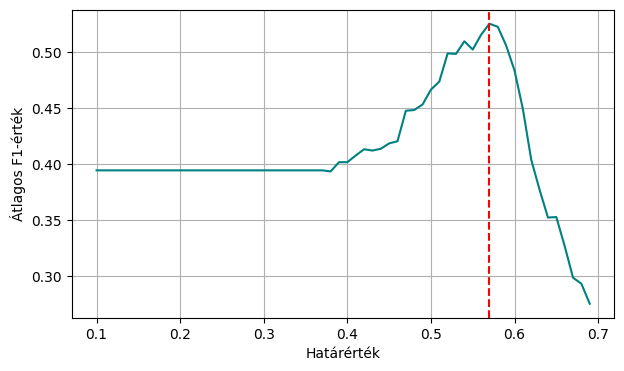

              precision    recall  f1-score   support

           0       0.38      0.44      0.41       129
           1       0.67      0.61      0.64       241

    accuracy                           0.55       370
   macro avg       0.53      0.53      0.53       370
weighted avg       0.57      0.55      0.56       370



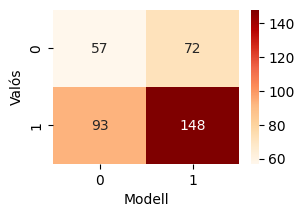

In [518]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
        #'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_O2.5_odds_market','prob_O2.5_odds_market']

premier_league_test_underover, pl_rf_uo=random_forest_test_underover(
    premier_league,
    target_col,
    drop,
    premier_league_params_underover)

In [355]:
def betting_RF_underover(df, stake=1):
    
    df = df.copy() 

    df['Profit'] = 0
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )

    total_profit = df['Profit'].sum()
    total_bets = len(df)

    roi = (total_profit / (total_bets * stake)) * 100
    
    print(f"ROI: {roi:.2f}%")

    df_profit = df[df['target_o2.5'] == df['Predicted']]
    df_loss = df[df['target_o2.5'] != df['Predicted']]

    return roi, df_profit, df_loss, df

roi, df_profit, df_loss, pred_odds = betting_RF_underover(premier_league_test_underover, stake=1)


ROI: -12.15%


>0% profit 12 fordulóban


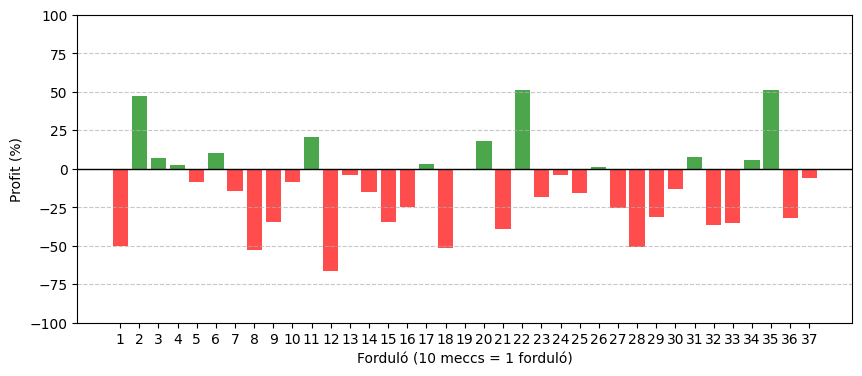

In [356]:
def ROI_sim_UO(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({'Profit': 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round['Profit'] / (roi_per_round['Total_Bets'] * stake)) * 100

    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 100)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(r'abrak/PL_ROI.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_UO(premier_league_test_underover, round_size=10)


## Bundesliga

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)
teszt halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)
teszt halmaz:  (i: 2674 -> 2970)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 2, 'n_estimators': 1000})

 legjobb threshold: 0.53, legjobb F1: 0.5152


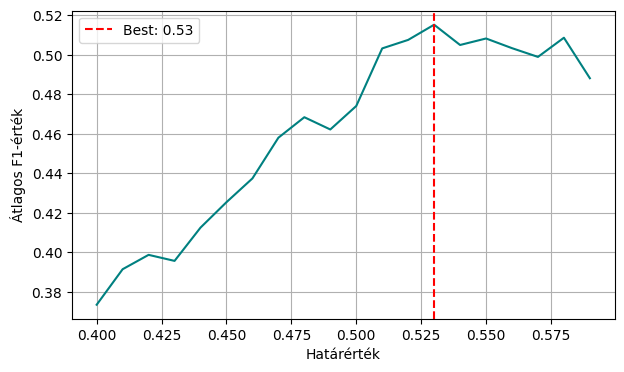

Validation accuracy: 0.5758
val eredmények:
              precision    recall  f1-score   support

           0       0.45      0.28      0.34       119
           1       0.62      0.78      0.69       178

    accuracy                           0.58       297
   macro avg       0.53      0.53      0.52       297
weighted avg       0.55      0.58      0.55       297



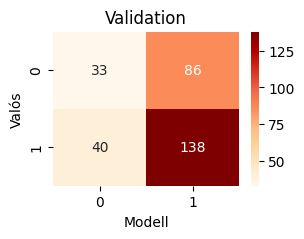


test accuracy: 0.6566
test eredmények:
              precision    recall  f1-score   support

           0       0.66      0.19      0.29       112
           1       0.66      0.94      0.77       185

    accuracy                           0.66       297
   macro avg       0.66      0.56      0.53       297
weighted avg       0.66      0.66      0.59       297



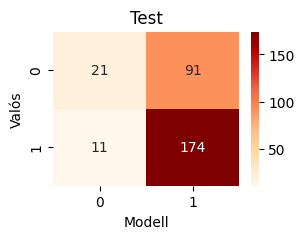


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.065247
57     prob_O2.5_odds_market    0.054388
55     prob_Draw_odds_market    0.040438
7                 home_xg_RA    0.032713
44          home_clinicality    0.031289
32              away_ppda_RA    0.030828
10              home_ppda_RA    0.030393
6    home_expected_points_RA    0.030033
8              home_np_xg_RA    0.029164
9   home_np_xg_difference_RA    0.028773
31  away_np_xg_difference_RA    0.028388
11  home_deep_completions_RA    0.027301
54    prob_AwayW_odds_market    0.026420
53    prob_HomeW_odds_market    0.025195
45          away_clinicality    0.023866


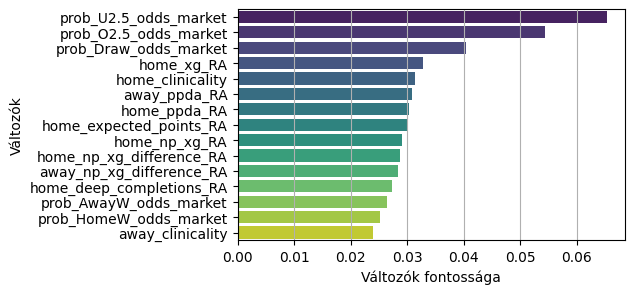

In [351]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
#        'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_U2.5_odds_market','prob_O2.5_odds_market']


bundesliga_tuning_underover,bundesliga_test_underover, bundesliga_topfeatures_underover, gr_rf_uo = random_forest_tuning_underover(
    bundesliga,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 2673)
teszt halmaz:  (i: 2674 -> 2970)

 legjobb threshold: 0.60, legjobb F1: 0.6363


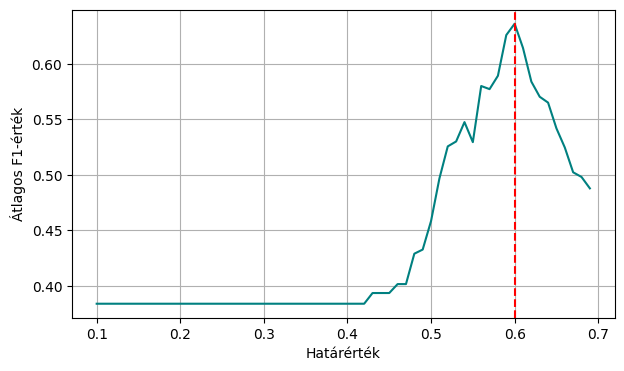

              precision    recall  f1-score   support

           0       0.54      0.58      0.56       112
           1       0.73      0.70      0.71       185

    accuracy                           0.65       297
   macro avg       0.64      0.64      0.64       297
weighted avg       0.66      0.65      0.66       297



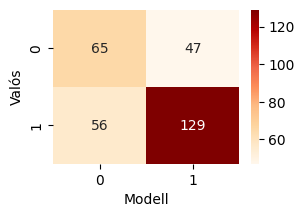

In [530]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
        #'prob_HomeW_odds_market','prob_AwayW_odds_market','prob_Draw_odds_market','prob_O2.5_odds_market','prob_O2.5_odds_market']

bundesliga_test_underover, bl_rf_uo = random_forest_test_underover(
    bundesliga,
    target_col,
    drop,
    bundesliga_params_underover
)

In [358]:
roi_bundesliga, df_profit_bundesliga, df_loss_bundesliga, pred_odds_bundesliga = betting_RF_underover(
    bundesliga_test_underover, stake=1
)

ROI: 3.85%


>0% profit 21 fordulóban


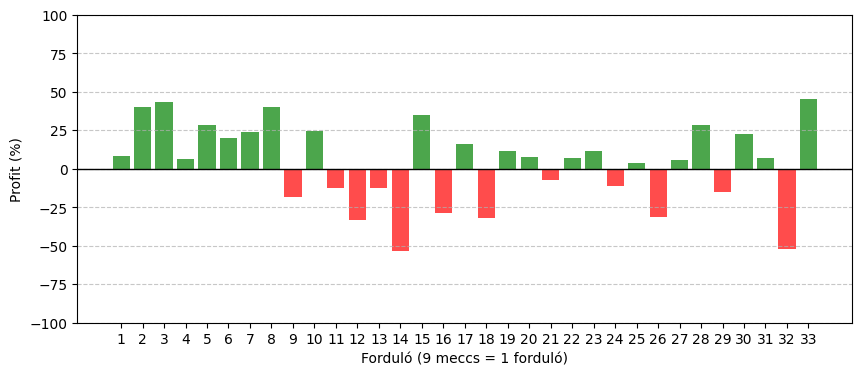

In [359]:
roi_sim_UO_bundesliga = ROI_sim_UO(bundesliga_test_underover, round_size=9)

## serie A

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)
teszt halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)
teszt halmaz:  (i: 3221 -> 3578)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 49, 'max_features': 'log2', 'min_samples_leaf': 18, 'min_samples_split': 2, 'n_estimators': 185})

 legjobb threshold: 0.52, legjobb F1: 0.5585


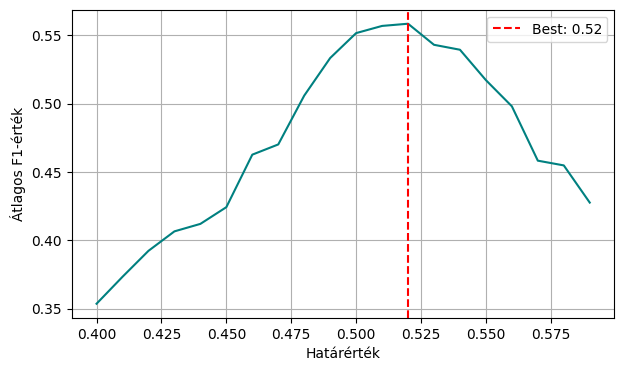

Validation accuracy: 0.5754
val eredmények:
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       196
           1       0.54      0.42      0.47       162

    accuracy                           0.58       358
   macro avg       0.57      0.56      0.56       358
weighted avg       0.57      0.58      0.57       358



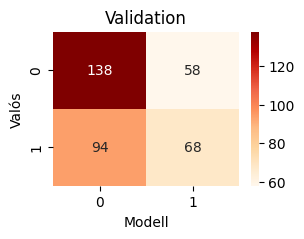


test accuracy: 0.5782
test eredmények:
              precision    recall  f1-score   support

           0       0.56      0.74      0.64       182
           1       0.61      0.41      0.49       176

    accuracy                           0.58       358
   macro avg       0.58      0.58      0.56       358
weighted avg       0.58      0.58      0.57       358



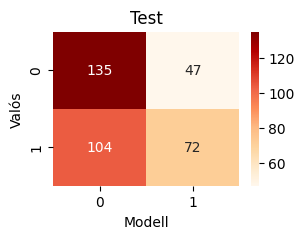


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.047573
57     prob_O2.5_odds_market    0.045548
55     prob_Draw_odds_market    0.036458
44          home_clinicality    0.033367
7                 home_xg_RA    0.032279
31  away_np_xg_difference_RA    0.031323
53    prob_HomeW_odds_market    0.029313
32              away_ppda_RA    0.028565
8              home_np_xg_RA    0.028365
54    prob_AwayW_odds_market    0.027011
45          away_clinicality    0.026749
29                away_xg_RA    0.026462
2              home_shots_RA    0.025595
28   away_expected_points_RA    0.025491
10              home_ppda_RA    0.024865


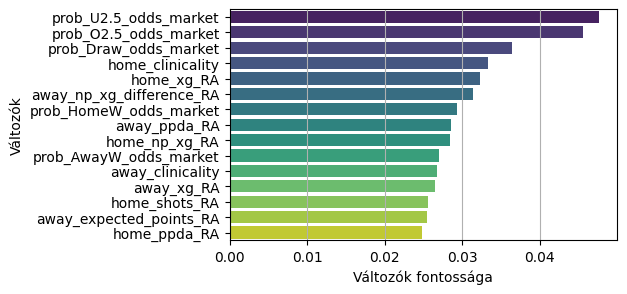

In [352]:
serie_a_tuning_underover, serie_a_test_underover, serie_a_topfeatures_underover, it_rf_uo = random_forest_tuning_underover(
    serie_a,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 3220)
teszt halmaz:  (i: 3221 -> 3578)

 legjobb threshold: 0.49, legjobb F1: 0.5724


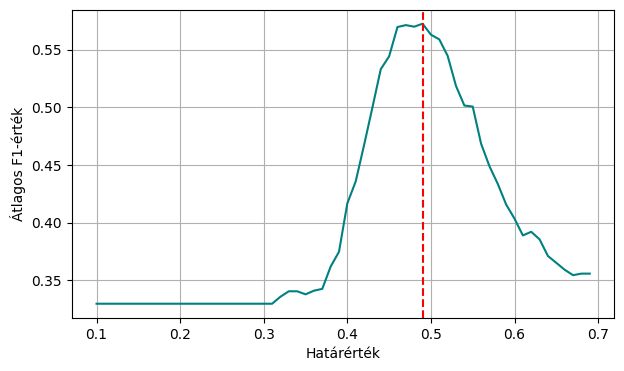

              precision    recall  f1-score   support

           0       0.58      0.59      0.58       182
           1       0.57      0.56      0.56       176

    accuracy                           0.57       358
   macro avg       0.57      0.57      0.57       358
weighted avg       0.57      0.57      0.57       358



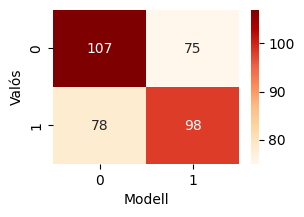

In [122]:
serie_a_test_underover, it_rf_uo = random_forest_test_underover(
    serie_a,
    target_col,
    drop,
    serie_a_params_underover
)

In [360]:
roi_serie_a, df_profit_serie_a, df_loss_serie_a, pred_odds_serie_a = betting_RF_underover(
    serie_a_test_underover, stake=1
)

ROI: 1.00%


>0% profit 17 fordulóban


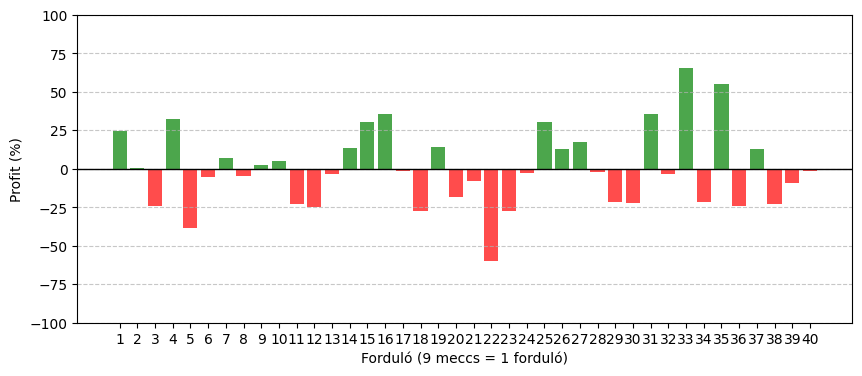

In [98]:
roi_sim_UO_serie_a = ROI_sim_UO(serie_a_test_underover, round_size=9)


## La Liga

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)
teszt halmaz dimenziók: (369, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
teszt halmaz:  (i: 3329 -> 3697)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 19, 'n_estimators': 163})

 legjobb threshold: 0.47, legjobb F1: 0.5872


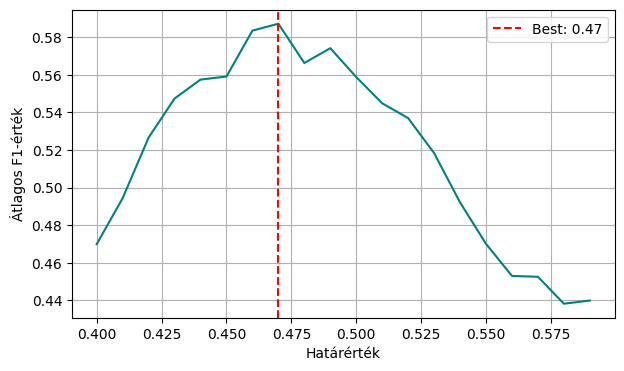

Validation accuracy: 0.5892
val eredmények:
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       195
           1       0.57      0.55      0.56       175

    accuracy                           0.59       370
   macro avg       0.59      0.59      0.59       370
weighted avg       0.59      0.59      0.59       370



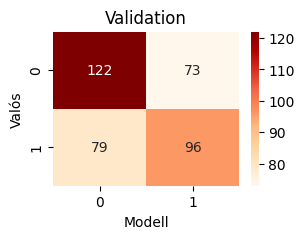


test accuracy: 0.5501
test eredmények:
              precision    recall  f1-score   support

           0       0.59      0.53      0.56       197
           1       0.52      0.57      0.54       172

    accuracy                           0.55       369
   macro avg       0.55      0.55      0.55       369
weighted avg       0.55      0.55      0.55       369



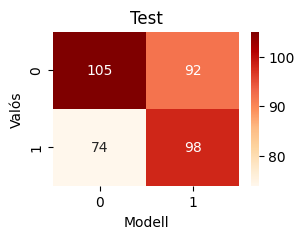


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.039139
57     prob_O2.5_odds_market    0.038196
55     prob_Draw_odds_market    0.033699
32              away_ppda_RA    0.030576
10              home_ppda_RA    0.029972
7                 home_xg_RA    0.028391
31  away_np_xg_difference_RA    0.028000
54    prob_AwayW_odds_market    0.027766
28   away_expected_points_RA    0.027663
6    home_expected_points_RA    0.027496
30             away_np_xg_RA    0.027219
29                away_xg_RA    0.026950
9   home_np_xg_difference_RA    0.026499
44          home_clinicality    0.026249
8              home_np_xg_RA    0.026065


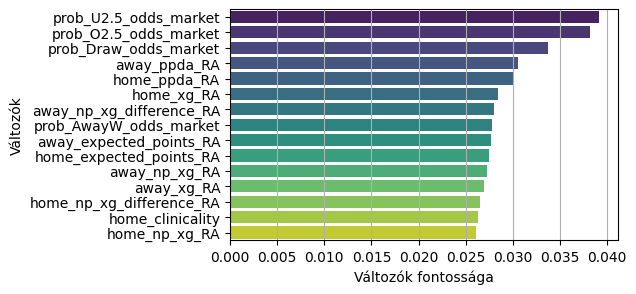

In [353]:
la_liga_tuning_underover, la_liga_test_underover, la_liga_topfeatures_underover,sp_rf_uo  = random_forest_tuning_underover(
    la_liga,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 3327)
teszt halmaz:  (i: 3328 -> 3697)

 legjobb threshold: 0.50, legjobb F1: 0.6041


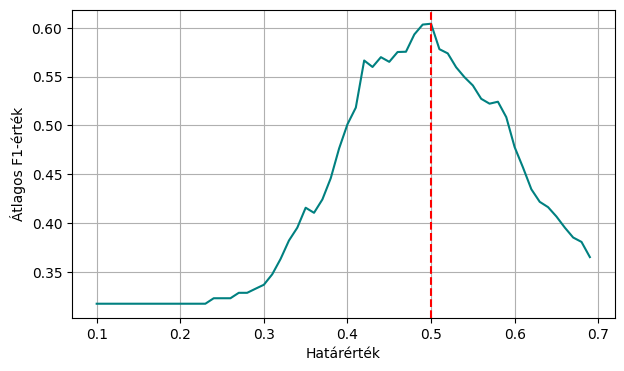

              precision    recall  f1-score   support

           0       0.62      0.72      0.67       198
           1       0.60      0.49      0.54       172

    accuracy                           0.61       370
   macro avg       0.61      0.61      0.60       370
weighted avg       0.61      0.61      0.61       370



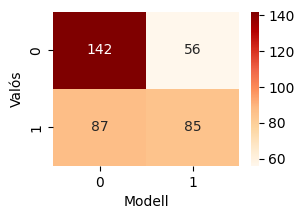

In [123]:
la_liga_test_underover, sp_rf_uo = random_forest_test_underover(
    la_liga,
    target_col,
    drop,
    la_liga_params_underover
)

In [361]:
roi_la_liga, df_profit_la_liga, df_loss_la_liga, pred_odds_la_liga = betting_RF_underover(
    la_liga_test_underover, stake=1
)

ROI: -4.94%


>0% profit 19 fordulóban


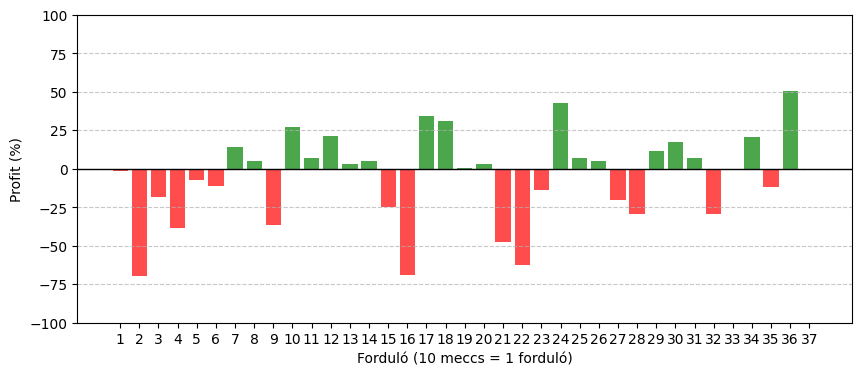

In [364]:
roi_sim_UO_la_liga = ROI_sim_UO(la_liga_test_underover, round_size=10)

## Ligue 1

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)
teszt halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)
teszt halmaz:  (i: 3170 -> 3521)

legjobb modell hiperparameterei: OrderedDict({'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 17, 'min_samples_split': 2, 'n_estimators': 1000})

 legjobb threshold: 0.59, legjobb F1: 0.5767


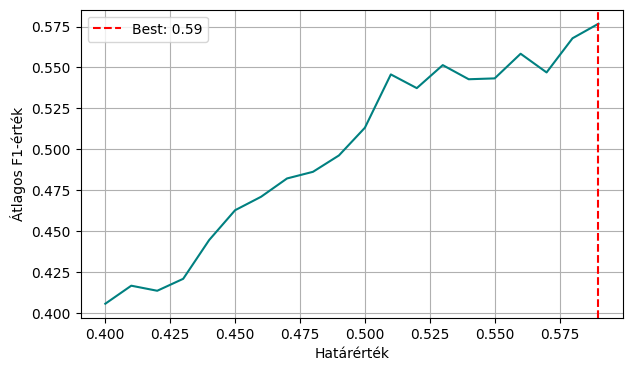

Validation accuracy: 0.5767
val eredmények:
              precision    recall  f1-score   support

           0       0.51      0.66      0.58       153
           1       0.66      0.51      0.58       199

    accuracy                           0.58       352
   macro avg       0.59      0.59      0.58       352
weighted avg       0.60      0.58      0.58       352



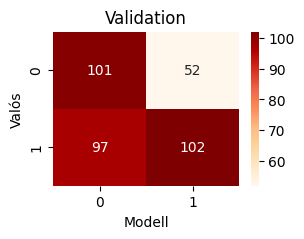


test accuracy: 0.5824
test eredmények:
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       163
           1       0.67      0.44      0.53       189

    accuracy                           0.58       352
   macro avg       0.60      0.59      0.58       352
weighted avg       0.61      0.58      0.57       352



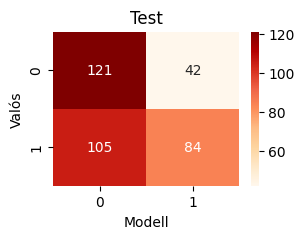


top15 valtozo:
                     feature  importance
57     prob_O2.5_odds_market    0.055112
56     prob_U2.5_odds_market    0.053073
55     prob_Draw_odds_market    0.045019
7                 home_xg_RA    0.033505
8              home_np_xg_RA    0.031036
9   home_np_xg_difference_RA    0.030152
53    prob_HomeW_odds_market    0.029960
54    prob_AwayW_odds_market    0.029572
10              home_ppda_RA    0.029362
30             away_np_xg_RA    0.026780
6    home_expected_points_RA    0.026441
11  home_deep_completions_RA    0.026151
29                away_xg_RA    0.025961
32              away_ppda_RA    0.025837
44          home_clinicality    0.025759


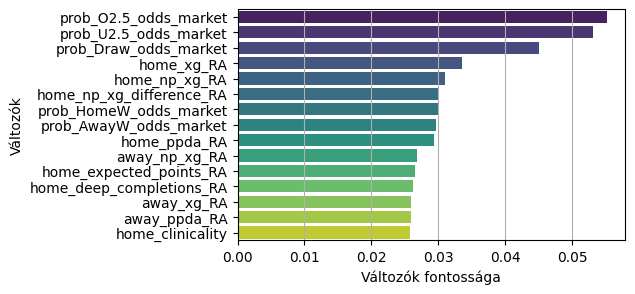

In [354]:
ligue_1_tuning_underover, ligue_1_test_underover, ligue_1_topfeatures_underover, fr_rf_uo = random_forest_tuning_underover(
    ligue_1,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 3169)
teszt halmaz:  (i: 3170 -> 3521)

 legjobb threshold: 0.58, legjobb F1: 0.5657


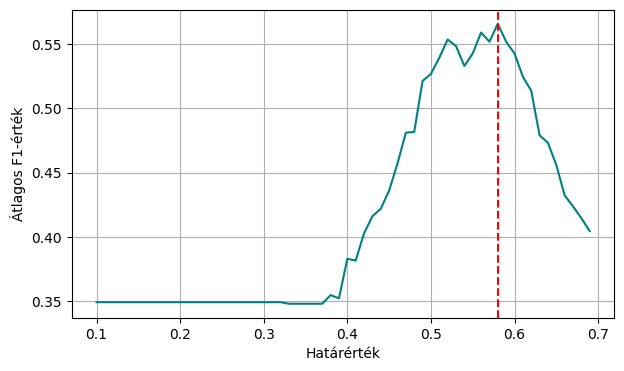

              precision    recall  f1-score   support

           0       0.53      0.74      0.61       163
           1       0.65      0.43      0.52       189

    accuracy                           0.57       352
   macro avg       0.59      0.58      0.57       352
weighted avg       0.59      0.57      0.56       352



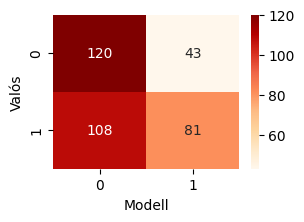

In [124]:
ligue_1_test_underover, fr_rf_uo = random_forest_test_underover(
    ligue_1,
    target_col,
    drop,
    ligue_1_params_underover
)

In [363]:
roi_ligue_1, df_profit_ligue_1, df_loss_ligue_1, pred_odds_ligue_1 = betting_RF_underover(
    ligue_1_test_underover, stake=1
)

ROI: 3.84%


>0% profit 20 fordulóban


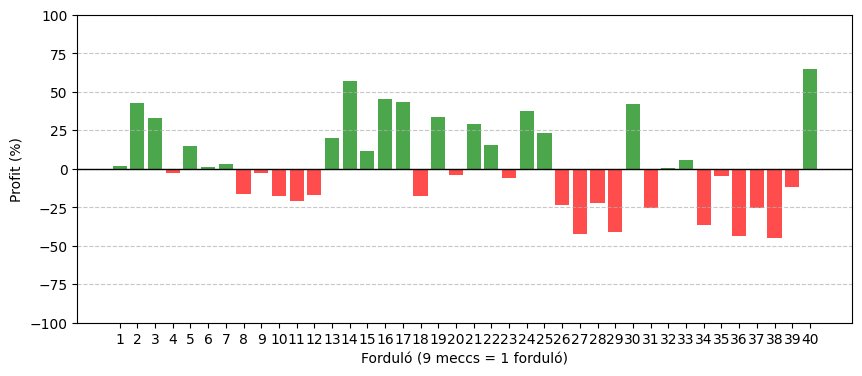

In [106]:
roi_sim_UO_ligue_1 = ROI_sim_UO(ligue_1_test_underover, round_size=9)

## Kombinált

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)

legjobb modell hiperparameterei: OrderedDict({'class_weight': None, 'criterion': 'entropy', 'max_depth': 29, 'max_features': 'log2', 'min_samples_leaf': 20, 'min_samples_split': 16, 'n_estimators': 477})

 legjobb threshold: 0.52, legjobb F1: 0.5718


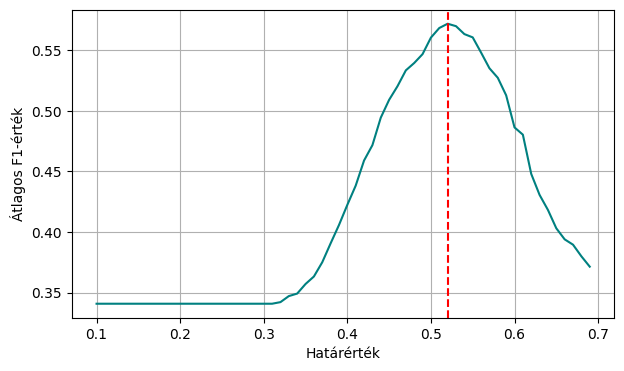

accuracy: 0.5739
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       843
           1       0.58      0.62      0.60       903

    accuracy                           0.57      1746
   macro avg       0.57      0.57      0.57      1746
weighted avg       0.57      0.57      0.57      1746



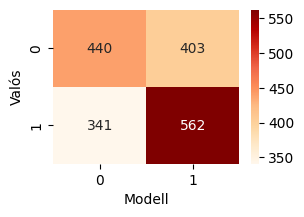


top15 valtozo:
                     feature  importance
56     prob_U2.5_odds_market    0.060304
57     prob_O2.5_odds_market    0.058295
55     prob_Draw_odds_market    0.044333
7                 home_xg_RA    0.030309
53    prob_HomeW_odds_market    0.029093
54    prob_AwayW_odds_market    0.028833
8              home_np_xg_RA    0.028367
6    home_expected_points_RA    0.027579
10              home_ppda_RA    0.026714
32              away_ppda_RA    0.026620
30             away_np_xg_RA    0.026575
9   home_np_xg_difference_RA    0.026434
29                away_xg_RA    0.026327
28   away_expected_points_RA    0.025936
31  away_np_xg_difference_RA    0.025791


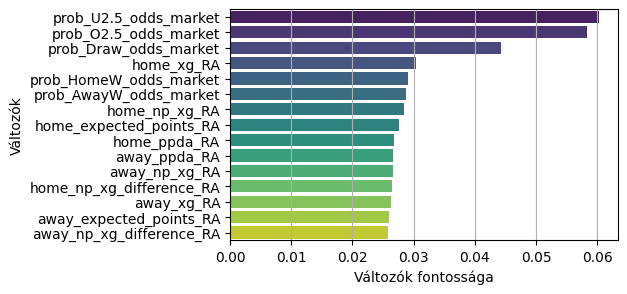

In [107]:
big5_tuning_underover, big5_test_underover, big5_topfeatures_underover, big5_rf_uo = random_forest_tuning_underover(
    big5,
    target_col,
    drop
)


tanító halmaz indexek: (i: 1 -> 15718)
teszt halmaz:  (i: 15719 -> 17464)

 legjobb threshold: 0.54, legjobb F1: 0.6006


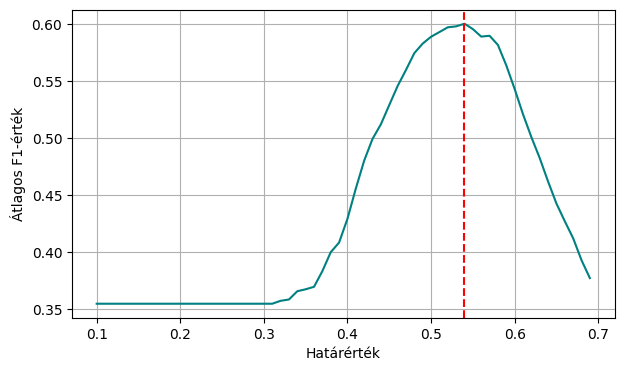

              precision    recall  f1-score   support

           0       0.56      0.57      0.57       786
           1       0.64      0.63      0.64       960

    accuracy                           0.60      1746
   macro avg       0.60      0.60      0.60      1746
weighted avg       0.60      0.60      0.60      1746



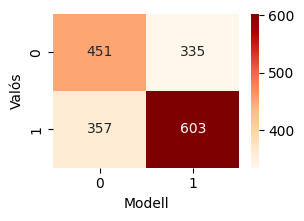

In [108]:
big5_test_underover = random_forest_test_underover(
    big5,
    target_col,
    drop,
    big5_params_underover
)


In [109]:
roi_big5, df_profit_big5, df_loss_big5, pred_odds_big5 = betting_RF_underover(
    big5_test_underover, stake=1
)


ROI: 0.05%


>0% profit 19 fordulóban


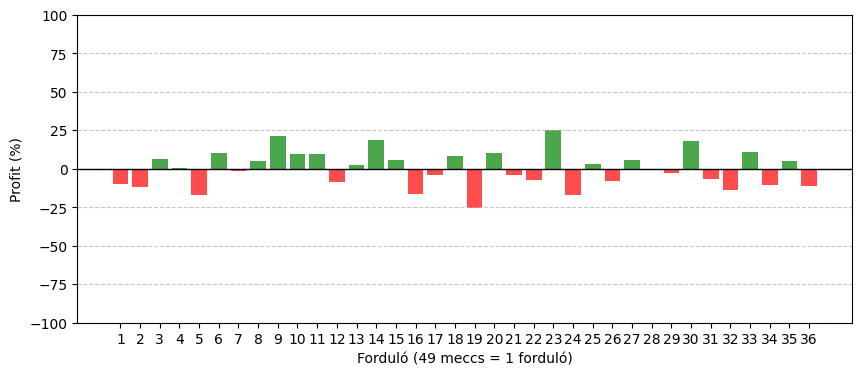

In [111]:
roi_sim_UO_big5 = ROI_sim_UO(big5_test_underover, round_size=49)

# összehasonlítás

## UO

### PL

In [529]:
def rf_dict_uo(model, input_df, df_dict, target_col, drop_cols=[], stake=1):
    
    results = {}
    scaler_fit_idx = int(len(input_df) * 0.8)
    scaler_fit_data = input_df.iloc[:scaler_fit_idx].drop(columns=[target_col] + drop_cols + odds)

    for league_name, df in df_dict.items():
        print(f"\n=== {league_name} ===")
        
        df_cleaned = df.dropna().reset_index(drop=True)

        X_base = df_cleaned.drop(columns=[target_col] + drop_cols)
        y_base = df_cleaned[target_col]

        chunk_size = len(df_cleaned) // 10
        test_results = []

        for i in range(10):
            start_idx = i * chunk_size
            end_idx = len(df_cleaned) if i == 9 else (i + 1) * chunk_size

            X_chunk = X_base.iloc[start_idx:end_idx].reset_index(drop=True)
            y_chunk = y_base.iloc[start_idx:end_idx].reset_index(drop=True)
            df_chunk = df_cleaned.iloc[start_idx:end_idx].copy()

            probs_chunk = model.predict_proba(X_chunk)
            preds_chunk = (probs_chunk[:, 1] >= 0.5).astype(int)

            acc = accuracy_score(y_chunk, preds_chunk)
            f1 = f1_score(y_chunk, preds_chunk, average='macro')

            df_chunk['Predicted'] = preds_chunk
            df_chunk['Profit'] = df_chunk.apply(
                lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row[target_col] == 1 else
                            (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row[target_col] == 0 else
                            -stake, axis=1
            )
            total_profit = df_chunk['Profit'].sum()
            roi = (total_profit / (len(df_chunk) * stake)) * 100

            print(f"{i+1}. szezon: Pontosság = {acc:.4f}, F1-macro = {f1:.4f}, ROI = {roi:.2f}%")
            print(f"Indexek: {start_idx} - {end_idx - 1}")

            test_results.append({
                'season': i + 1,
                'start_idx': start_idx,
                'end_idx': end_idx - 1,
                'accuracy': acc,
                'f1_macro': f1,
                'roi': roi
            })


        X_final = X_base.copy()

        probs_all = model.predict_proba(X_final)
        preds_all = (probs_all[:, 1] >= 0.5).astype(int)

        acc_all = accuracy_score(y_base, preds_all)
        f1_all = f1_score(y_base, preds_all, average='macro')

        df_result = df_cleaned.copy()
        df_result['P_0'] = probs_all[:, 0]
        df_result['P_1'] = probs_all[:, 1]
        df_result['Predicted'] = preds_all

        df_result['Profit'] = df_result.apply(
            lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row[target_col] == 1 else
                        (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row[target_col] == 0 else
                        -stake, axis=1
        )
        total_profit = df_result['Profit'].sum()
        roi_all = (total_profit / (len(df_result) * stake)) * 100

        print(f"\nTeljes adathalmaz: Pontosság = {acc_all:.4f}, F1-macro = {f1_all:.4f}, ROI = {roi_all:.2f}%")

        results[league_name] = {
            'predictions': df_result,
            'partial_scores': test_results,
            'full_scores': {
                'accuracy': acc_all,
                'f1_macro': f1_all,
                'roi': roi_all
            }
        }

    return results


pl_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Serie A':serie_a,
    'Bundesliga':bundesliga
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_pl = rf_dict_uo(
    model=pl_rf_uo,
    input_df=premier_league,
    df_dict=pl_dict,
    target_col='target_o2.5',
    drop_cols=drop
)



=== La Liga ===
1. szezon: Pontosság = 0.5664, F1-macro = 0.5657, ROI = -8.04%
Indexek: 0 - 368
2. szezon: Pontosság = 0.5745, F1-macro = 0.5742, ROI = -5.78%
Indexek: 369 - 737
3. szezon: Pontosság = 0.5772, F1-macro = 0.5746, ROI = -6.14%
Indexek: 738 - 1106
4. szezon: Pontosság = 0.5664, F1-macro = 0.5647, ROI = -8.10%
Indexek: 1107 - 1475
5. szezon: Pontosság = 0.5474, F1-macro = 0.5472, ROI = -10.26%
Indexek: 1476 - 1844
6. szezon: Pontosság = 0.5881, F1-macro = 0.5787, ROI = -3.69%
Indexek: 1845 - 2213
7. szezon: Pontosság = 0.5637, F1-macro = 0.5398, ROI = -7.33%
Indexek: 2214 - 2582
8. szezon: Pontosság = 0.5772, F1-macro = 0.5610, ROI = -1.48%
Indexek: 2583 - 2951
9. szezon: Pontosság = 0.5827, F1-macro = 0.5732, ROI = -1.25%
Indexek: 2952 - 3320
10. szezon: Pontosság = 0.6303, F1-macro = 0.6281, ROI = 5.52%
Indexek: 3321 - 3696

Teljes adathalmaz: Pontosság = 0.5775, F1-macro = 0.5755, ROI = -4.63%

=== Ligue 1 ===
1. szezon: Pontosság = 0.6023, F1-macro = 0.5417, ROI = -0.4

### Bundesliga

In [534]:
bundesliga_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Serie A':serie_a,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_bundesliga = rf_dict_uo(
    model=bl_rf_uo,
    input_df=bundesliga,
    df_dict=bundesliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)



=== La Liga ===
1. szezon: Pontosság = 0.5745, F1-macro = 0.5733, ROI = -5.95%
Indexek: 0 - 368
2. szezon: Pontosság = 0.5393, F1-macro = 0.5280, ROI = -10.42%
Indexek: 369 - 737
3. szezon: Pontosság = 0.5745, F1-macro = 0.5630, ROI = -6.60%
Indexek: 738 - 1106
4. szezon: Pontosság = 0.5556, F1-macro = 0.5439, ROI = -9.11%
Indexek: 1107 - 1475
5. szezon: Pontosság = 0.5528, F1-macro = 0.5475, ROI = -7.42%
Indexek: 1476 - 1844
6. szezon: Pontosság = 0.5827, F1-macro = 0.5824, ROI = -2.90%
Indexek: 1845 - 2213
7. szezon: Pontosság = 0.5447, F1-macro = 0.5410, ROI = -8.07%
Indexek: 2214 - 2582
8. szezon: Pontosság = 0.5312, F1-macro = 0.5303, ROI = -8.01%
Indexek: 2583 - 2951
9. szezon: Pontosság = 0.5664, F1-macro = 0.5664, ROI = -2.42%
Indexek: 2952 - 3320
10. szezon: Pontosság = 0.5984, F1-macro = 0.5971, ROI = 1.46%
Indexek: 3321 - 3696

Teljes adathalmaz: Pontosság = 0.5621, F1-macro = 0.5608, ROI = -5.93%

=== Ligue 1 ===
1. szezon: Pontosság = 0.5938, F1-macro = 0.5557, ROI = -0.5

### Serie A

In [537]:
seriea_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_seriea = rf_dict_uo(
    model=it_rf_uo,
    input_df=serie_a,
    df_dict=seriea_dict,
    target_col='target_o2.5',
    drop_cols=drop
)



=== La Liga ===
1. szezon: Pontosság = 0.5881, F1-macro = 0.5862, ROI = -3.12%
Indexek: 0 - 368
2. szezon: Pontosság = 0.5474, F1-macro = 0.5455, ROI = -9.68%
Indexek: 369 - 737
3. szezon: Pontosság = 0.6152, F1-macro = 0.6077, ROI = 1.80%
Indexek: 738 - 1106
4. szezon: Pontosság = 0.5854, F1-macro = 0.5794, ROI = -2.96%
Indexek: 1107 - 1475
5. szezon: Pontosság = 0.5610, F1-macro = 0.5607, ROI = -6.19%
Indexek: 1476 - 1844
6. szezon: Pontosság = 0.5528, F1-macro = 0.5481, ROI = -9.43%
Indexek: 1845 - 2213
7. szezon: Pontosság = 0.5610, F1-macro = 0.5486, ROI = -5.60%
Indexek: 2214 - 2582
8. szezon: Pontosság = 0.5583, F1-macro = 0.5463, ROI = -3.33%
Indexek: 2583 - 2951
9. szezon: Pontosság = 0.5827, F1-macro = 0.5779, ROI = -0.21%
Indexek: 2952 - 3320
10. szezon: Pontosság = 0.5984, F1-macro = 0.5982, ROI = 0.87%
Indexek: 3321 - 3696

Teljes adathalmaz: Pontosság = 0.5751, F1-macro = 0.5747, ROI = -3.78%

=== Ligue 1 ===
1. szezon: Pontosság = 0.5739, F1-macro = 0.5157, ROI = -4.18%

### La Liga

In [539]:
laliga_dict = {
    'Serie A': serie_a,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_laliga = rf_dict_uo(
    model=sp_rf_uo,
    input_df=la_liga,
    df_dict=laliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)



=== Serie A ===
1. szezon: Pontosság = 0.5490, F1-macro = 0.5368, ROI = -2.14%
Indexek: 0 - 356
2. szezon: Pontosság = 0.5378, F1-macro = 0.5253, ROI = -5.67%
Indexek: 357 - 713
3. szezon: Pontosság = 0.5434, F1-macro = 0.5397, ROI = -7.98%
Indexek: 714 - 1070
4. szezon: Pontosság = 0.5462, F1-macro = 0.5407, ROI = -7.97%
Indexek: 1071 - 1427
5. szezon: Pontosság = 0.5070, F1-macro = 0.5046, ROI = -10.61%
Indexek: 1428 - 1784
6. szezon: Pontosság = 0.5742, F1-macro = 0.5577, ROI = -1.56%
Indexek: 1785 - 2141
7. szezon: Pontosság = 0.5630, F1-macro = 0.5471, ROI = -2.73%
Indexek: 2142 - 2498
8. szezon: Pontosság = 0.5630, F1-macro = 0.5450, ROI = -1.06%
Indexek: 2499 - 2855
9. szezon: Pontosság = 0.5210, F1-macro = 0.5071, ROI = -7.13%
Indexek: 2856 - 3212
10. szezon: Pontosság = 0.5644, F1-macro = 0.5523, ROI = -0.45%
Indexek: 3213 - 3577

Teljes adathalmaz: Pontosság = 0.5470, F1-macro = 0.5469, ROI = -4.72%

=== Ligue 1 ===
1. szezon: Pontosság = 0.6080, F1-macro = 0.5460, ROI = 2.5

### Ligue 1

In [541]:
ligue1_dict = {
    'Serie A': serie_a,
    'La Liga':la_liga,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

general_ligue1 = rf_dict_uo(
    model=fr_rf_uo,
    input_df=ligue_1,
    df_dict=ligue1_dict,
    target_col='target_o2.5',
    drop_cols=drop
)



=== Serie A ===
1. szezon: Pontosság = 0.4958, F1-macro = 0.4903, ROI = -12.13%
Indexek: 0 - 356
2. szezon: Pontosság = 0.5098, F1-macro = 0.5098, ROI = -10.89%
Indexek: 357 - 713
3. szezon: Pontosság = 0.5518, F1-macro = 0.5192, ROI = -7.12%
Indexek: 714 - 1070
4. szezon: Pontosság = 0.5574, F1-macro = 0.5221, ROI = -6.97%
Indexek: 1071 - 1427
5. szezon: Pontosság = 0.5238, F1-macro = 0.4923, ROI = -9.04%
Indexek: 1428 - 1784
6. szezon: Pontosság = 0.6050, F1-macro = 0.5283, ROI = 1.75%
Indexek: 1785 - 2141
7. szezon: Pontosság = 0.5658, F1-macro = 0.4842, ROI = -6.01%
Indexek: 2142 - 2498
8. szezon: Pontosság = 0.5406, F1-macro = 0.4613, ROI = -7.56%
Indexek: 2499 - 2855
9. szezon: Pontosság = 0.5294, F1-macro = 0.5225, ROI = -6.19%
Indexek: 2856 - 3212
10. szezon: Pontosság = 0.5890, F1-macro = 0.5877, ROI = 3.85%
Indexek: 3213 - 3577

Teljes adathalmaz: Pontosság = 0.5470, F1-macro = 0.5228, ROI = -6.01%

=== La Liga ===
1. szezon: Pontosság = 0.5854, F1-macro = 0.5841, ROI = -3.8

## FTR

### Függvények definiálása

In [452]:
def random_forest_general(df, df_test, drop_cols_home=[], drop_cols_away=[], 
                          best_params_home={}, best_params_away={},
                          df_name='', df_test_name=''):
  
    df = df.dropna().reset_index(drop=True)
    df_test = df_test.dropna().reset_index(drop=True)

    """
    Szétválasztom a train, val és test seteket.
    A train az első 8 szezon.
    A val a 9.
    A test a 10. A lényeg, hogy a test másik ligából jön.

    Pl. Ha a PL-t hasonlítom össze a többi ligával, akkor
        A train a PL első 8 szezonja,  ezen történik a CV, hiperpm-hangolás
        A val a 9. szezonja, ezen történik a határérték kiválasztása - előrejelzek ezen is, majd azt
        a határértéket választom, amely maximalizálja a val halmazon az F1 macrot.
        A test pedig minden más liga 10. szezonja. Ezen csak előrejelzek, és a szavazókkal osztályzok - azt a határértéket használom, 
        amit a valon maximalizáltam. 
    """
    
    train_n = int(round(len(df) * 0.8, 0)) 
    train_set = df.iloc[:train_n].copy()
    val_set = df.iloc[train_n:].copy()

    chunk_size = int(len(df_test) * 0.1)
    all_test_results = []
    original_df_test = df_test.copy()

    """
    checking
    """
    
    print(f"train_set indexek: {train_set.index[0]}–{train_set.index[-1]} | forrás: {df_name}")
    print(f"val_set indexek: {val_set.index[0]}–{val_set.index[-1]} | forrás: {df_name}")
    print(f"test_set - 10 darab 10%-os szelet a következőből: {df_test.index[0]}–{df_test.index[-1]} | forrás: {df_test_name}")

    """
    Tanítás a train adatokon, a CV során lementett legjobb hiperparaméterekkel.
    """
    
    rf_home = random_forest_validation(
        train_set, "target_home_win", drop_cols_home, best_params_home
    )

    rf_away = random_forest_validation(
        train_set, "target_away_win", drop_cols_away, best_params_away
    )

    """
    Előrejelzek a validációson, definiálom a vszgket, 0-1 között fixálom őket.
    """
    X_val = val_set.drop(columns=drop_cols_home + drop_cols_away + ["target_home_win", "target_away_win"])

    prob_home_win_val = rf_home.predict_proba(X_val)[:, 1]
    prob_away_win_val = rf_away.predict_proba(X_val)[:, 1]

    prob_home_win_val = np.maximum(prob_home_win_val, 0)
    prob_away_win_val = np.maximum(prob_away_win_val, 0)
    prob_draw_val = np.maximum(1 - (prob_home_win_val + prob_away_win_val), 0)

    total_prob_val = prob_home_win_val + prob_away_win_val + prob_draw_val
    prob_home_win_val /= total_prob_val
    prob_away_win_val /= total_prob_val
    prob_draw_val /= total_prob_val

    """
    Küszöb/határérték megállapítása.
    Tárolom az F1 macrot, végigiterálok a thresholds halmazán, frissítem az értéket, 
    ha magasabb, mint az aktuálisan maximum.
    Ez csak a validációs előrejelzésen történik.
    """
    
    best_f1_macro = 0
    best_threshold = 0.15
    thresholds = np.arange(0.01, 0.30, 0.01)

    true_outcomes_val = []
    for i in range(len(val_set)):
        if val_set.iloc[i]["target_home_win"] == 1:
            true_outcomes_val.append("Home Win")
        elif val_set.iloc[i]["target_away_win"] == 1:
            true_outcomes_val.append("Away Win")
        else:
            true_outcomes_val.append("Draw")

    for threshold in thresholds:
        predictions = []
        for i in range(len(X_val)):
            home_prob = prob_home_win_val[i]
            away_prob = prob_away_win_val[i]
            
            if abs(home_prob - away_prob) < threshold:
                predictions.append("Draw")
            elif home_prob > away_prob:
                predictions.append("Home Win")
            else:
                predictions.append("Away Win")

        f1_macro = f1_score(true_outcomes_val, predictions, average='macro')

        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_threshold = threshold

    """
    Előrejelzés a külső ligák teszthalmazán.
    Most mind a 10 darab 10%-os szeletre végezzük el az előrejelzést.
    """
    all_test_chunks = []
    
    for i in range(10):
        start_idx = i * chunk_size
        end_idx = start_idx + chunk_size
        
        if i == 9:
            end_idx = len(df_test)
        
        df_test_chunk = df_test.iloc[start_idx:end_idx].copy()
        
        if len(df_test_chunk) == 0:
            continue  
            
        print(f"Előrejelzés a {i+1}. tesztszeletben, indexek: {df_test_chunk.index[0]}-{df_test_chunk.index[-1]}")
        
        X_test = df_test_chunk.drop(columns=["target_home_win", "target_away_win"] + drop_cols_home + drop_cols_away)

        model_home_preds = rf_home.predict(X_test)
        model_away_preds = rf_away.predict(X_test)

        prob_home_win_test = rf_home.predict_proba(X_test)[:, 1]
        prob_away_win_test = rf_away.predict_proba(X_test)[:, 1]

        prob_home_win_test = np.maximum(prob_home_win_test, 0)
        prob_away_win_test = np.maximum(prob_away_win_test, 0)
        prob_draw_test = np.maximum(1 - (prob_home_win_test + prob_away_win_test), 0)

        total_prob_test = prob_home_win_test + prob_away_win_test + prob_draw_test
        prob_home_win_test /= total_prob_test
        prob_away_win_test /= total_prob_test
        prob_draw_test /= total_prob_test

        df_test_chunk.loc[df_test_chunk.index, "model_home"] = model_home_preds
        df_test_chunk.loc[df_test_chunk.index, "model_away"] = model_away_preds
        df_test_chunk.loc[df_test_chunk.index, "prob_home_win"] = prob_home_win_test
        df_test_chunk.loc[df_test_chunk.index, "prob_away_win"] = prob_away_win_test
        df_test_chunk.loc[df_test_chunk.index, "prob_draw"] = prob_draw_test

        """
        Szavazó algoritmusok minden al-teszt halmazhoz.
        """
        def voting_hard(row):
            if row["model_home"] == 1 and row["model_away"] == 0:
                return "Home Win"
            elif row["model_away"] == 1 and row["model_home"] == 0:
                return "Away Win"
            elif row["model_home"] == 0 and row["model_away"] == 0:
                return "Draw"
            elif row["model_home"] == 1 and row["model_away"] == 1:
                return "Home Win"
            else:
                return "-"

        def voting_soft(row):
            prob_home_win = row['prob_home_win']
            prob_away_win = row['prob_away_win']

            if abs(prob_home_win - prob_away_win) < best_threshold:
                return "Draw"
            elif prob_home_win > prob_away_win:
                return "Home Win"
            elif prob_home_win < prob_away_win:
                return "Away Win"
            else:
                return "-"

        df_test_chunk["test_pred_hard"] = df_test_chunk.apply(voting_hard, axis=1)
        df_test_chunk["test_pred_soft"] = df_test_chunk.apply(voting_soft, axis=1)
        
        all_test_chunks.append(df_test_chunk)
    
    df_test_results = pd.concat(all_test_chunks)

    """
    Az a küszöbérték, amellyel a val halmazon max. lett az F1 macro
    """
    print(f"Legjobb küszöbérték a validációs halmazon: {best_threshold:.2f}")

    return df_test_results, rf_home, rf_away

In [468]:
def evaluation_general(pred_odds):

    accuracy_hard = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    f1_macro_hard = f1_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"], average='macro')

    accuracy_soft = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    f1_macro_soft = f1_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"], average='macro')

    return (f1_macro_hard, accuracy_hard, f1_macro_soft, accuracy_soft)

In [490]:
def run_random_forest_on_dict(train_df, test_df_dict, drop_cols_home, drop_cols_away, 
                               best_params_home, best_params_away, train_name):
    results = {}
    f1_macro_records = []  

    for league_name, test_df in test_df_dict.items():
        print(f"\n{'='*50}\nFuttatás {train_name} → {league_name}\n{'='*50}")
        
        test_predictions, rf_home, rf_away = random_forest_general(
            train_df,
            test_df,
            drop_cols_home,
            drop_cols_away,
            best_params_home,
            best_params_away,
            df_name=train_name,
            df_test_name=league_name
        )
        
        pred_odds = process_predictions(test_predictions)
        
        roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_randomforest(
            pred_odds,
            stake=1
        )
        
        results[league_name] = {
            "test_predictions": test_predictions,
            "rf_home": rf_home,
            "rf_away": rf_away,
            "pred_odds": pred_odds,
            "roi_hard": roi_hard,
            "roi_soft": roi_soft,
            "df_profit_hard": df_profit_hard,
            "df_loss_hard": df_loss_hard,
            "df_profit_soft": df_profit_soft,
            "df_loss_soft": df_loss_soft,
            "pred_odds_soft": pred_odds_soft
        }
        
        chunk_size = int(len(test_df) * 0.1)
        segment_results = []
        
        print(f"\n{'='*30}\nSzegmensenkénti (10%-os) értékelés\n{'='*30}")
        
        f1_macro_hard_list = []
        accuracy_hard_list = []
        f1_macro_soft_list = []
        accuracy_soft_list = []
        roi_hard_list = []
        roi_soft_list = []

        for i in range(10):
            start_idx = i * chunk_size
            end_idx = start_idx + chunk_size
            
            if i == 9:
                end_idx = len(test_predictions)
            
            segment_predictions = test_predictions.iloc[start_idx:end_idx].copy() if start_idx < len(test_predictions) else None
            
            if segment_predictions is None or len(segment_predictions) == 0:
                print(f"\nSzegmens {i + 1}: Nincs elég adat")
                continue
            
            print(f"\n--- Szegmens {i + 1} (index: {start_idx}-{end_idx - 1}) ---")
            
            segment_pred_odds = process_predictions(segment_predictions)
            
            f1_macro_hard, accuracy_hard, f1_macro_soft, accuracy_soft = evaluation_general(segment_pred_odds)            
            segment_roi_hard, segment_roi_soft, _, _, _, _, _ = betting_randomforest(
                segment_pred_odds,
                stake=1,
            )

            print(f"F1 macro (Hard): {f1_macro_hard:.4f}, Pontosság (Hard): {accuracy_hard:.4f}")
            print(f"F1 macro (Soft): {f1_macro_soft:.4f}, Pontosság (Soft): {accuracy_soft:.4f}")
            print(f"ROI Hard: {segment_roi_hard:.2f}%, ROI Soft: {segment_roi_soft:.2f}%")
            
            f1_macro_hard_list.append(f1_macro_hard)
            accuracy_hard_list.append(accuracy_hard)
            f1_macro_soft_list.append(f1_macro_soft)
            accuracy_soft_list.append(accuracy_soft)
            roi_hard_list.append(segment_roi_hard)
            roi_soft_list.append(segment_roi_soft)

            f1_macro_records.append({
                "league_name": league_name,
                "segment": i + 1,
                "f1_macro_hard": f1_macro_hard,
                "f1_macro_soft": f1_macro_soft
            })
        
        avg_f1_macro_hard = np.mean(f1_macro_hard_list)
        std_f1_macro_hard = np.std(f1_macro_hard_list)

        avg_accuracy_hard = np.mean(accuracy_hard_list)
        std_accuracy_hard = np.std(accuracy_hard_list)

        avg_f1_macro_soft = np.mean(f1_macro_soft_list)
        std_f1_macro_soft = np.std(f1_macro_soft_list)

        avg_accuracy_soft = np.mean(accuracy_soft_list)
        std_accuracy_soft = np.std(accuracy_soft_list)

        avg_roi_hard = np.mean(roi_hard_list)
        avg_roi_soft = np.mean(roi_soft_list)

        print(f"\n{'='*30}\nÁtlagos értékek a {league_name} bajnokságban\n{'='*30}")
        print(f"Átlagos F1 macro (Hard Voting): {avg_f1_macro_hard:.4f} ± {std_f1_macro_hard:.4f}")
        print(f"Átlagos pontosság (Hard Voting): {avg_accuracy_hard:.4f} ± {std_accuracy_hard:.4f}")
        print(f"Átlagos ROI hard: {avg_roi_hard:.2f}%")
        print(f"Átlagos F1 macro (Soft Voting): {avg_f1_macro_soft:.4f} ± {std_f1_macro_soft:.4f}")
        print(f"Átlagos pontosság (Soft Voting): {avg_accuracy_soft:.4f} ± {std_accuracy_soft:.4f}")
        print(f"Átlagos ROI soft: {avg_roi_soft:.2f}%")
        
        results[league_name]["segment_results"] = segment_results

    f1_macro_df = pd.DataFrame(f1_macro_records)
    return results, f1_macro_df


### PL

In [491]:
pl_dict = {
    'La Liga': la_liga,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga
}

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_pl, pl_f1_macro_df = run_random_forest_on_dict(
    premier_league,
    pl_dict,
    drop_cols_home,
    drop_cols_away,
    premier_league_params_home,
    premier_league_params_away,
    train_name='Premier League'
)



Futtatás Premier League → La Liga
train_set indexek: 0–2957 | forrás: Premier League
val_set indexek: 2958–3697 | forrás: Premier League
test_set - 10 darab 10%-os szelet a következőből: 0–3696 | forrás: La Liga
Előrejelzés a 1. tesztszeletben, indexek: 0-368
Előrejelzés a 2. tesztszeletben, indexek: 369-737
Előrejelzés a 3. tesztszeletben, indexek: 738-1106
Előrejelzés a 4. tesztszeletben, indexek: 1107-1475
Előrejelzés a 5. tesztszeletben, indexek: 1476-1844
Előrejelzés a 6. tesztszeletben, indexek: 1845-2213
Előrejelzés a 7. tesztszeletben, indexek: 2214-2582
Előrejelzés a 8. tesztszeletben, indexek: 2583-2951
Előrejelzés a 9. tesztszeletben, indexek: 2952-3320
Előrejelzés a 10. tesztszeletben, indexek: 3321-3696
Legjobb küszöbérték a validációs halmazon: 0.12
ROI hard : 0.85%
ROI soft : -1.08%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : 4.96%
ROI soft : -1.78%
F1 macro (Hard): 0.5325, Pontosság (Hard): 0.5474
F1 macro (Soft): 0.5109, Pontosság

### Bundesliga

In [493]:
bundesliga_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Serie A':serie_a,
    'Premier League':premier_league
}

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_bundesliga, bundesliga_f1_macro = run_random_forest_on_dict(
    bundesliga,
    bundesliga_dict,
    drop_cols_home,
    drop_cols_away,
    bundesliga_params_home,
    bundesliga_params_away,
    train_name='Bundesliga'
)



Futtatás Bundesliga → La Liga
train_set indexek: 0–2375 | forrás: Bundesliga
val_set indexek: 2376–2969 | forrás: Bundesliga
test_set - 10 darab 10%-os szelet a következőből: 0–3696 | forrás: La Liga
Előrejelzés a 1. tesztszeletben, indexek: 0-368
Előrejelzés a 2. tesztszeletben, indexek: 369-737
Előrejelzés a 3. tesztszeletben, indexek: 738-1106
Előrejelzés a 4. tesztszeletben, indexek: 1107-1475
Előrejelzés a 5. tesztszeletben, indexek: 1476-1844
Előrejelzés a 6. tesztszeletben, indexek: 1845-2213
Előrejelzés a 7. tesztszeletben, indexek: 2214-2582
Előrejelzés a 8. tesztszeletben, indexek: 2583-2951
Előrejelzés a 9. tesztszeletben, indexek: 2952-3320
Előrejelzés a 10. tesztszeletben, indexek: 3321-3696
Legjobb küszöbérték a validációs halmazon: 0.09
ROI hard : -1.83%
ROI soft : 0.50%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : 2.23%
ROI soft : 4.91%
F1 macro (Hard): 0.5148, Pontosság (Hard): 0.5393
F1 macro (Soft): 0.5327, Pontosság (Soft): 0.57

### Serie A

In [495]:
seriea_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}


odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_seriea,seriea_f1_macro = run_random_forest_on_dict(
    serie_a,
    seriea_dict,
    drop_cols_home,
    drop_cols_away,
    serie_a_params_home,
    serie_a_params_away,
    train_name='Serie A'
)

Átlagos F1 macro (Soft Voting): 0.4527 ± 0.0139


Futtatás Serie A → La Liga
train_set indexek: 0–2861 | forrás: Serie A
val_set indexek: 2862–3577 | forrás: Serie A
test_set - 10 darab 10%-os szelet a következőből: 0–3696 | forrás: La Liga
Előrejelzés a 1. tesztszeletben, indexek: 0-368
Előrejelzés a 2. tesztszeletben, indexek: 369-737
Előrejelzés a 3. tesztszeletben, indexek: 738-1106
Előrejelzés a 4. tesztszeletben, indexek: 1107-1475
Előrejelzés a 5. tesztszeletben, indexek: 1476-1844
Előrejelzés a 6. tesztszeletben, indexek: 1845-2213
Előrejelzés a 7. tesztszeletben, indexek: 2214-2582
Előrejelzés a 8. tesztszeletben, indexek: 2583-2951
Előrejelzés a 9. tesztszeletben, indexek: 2952-3320
Előrejelzés a 10. tesztszeletben, indexek: 3321-3696
Legjobb küszöbérték a validációs halmazon: 0.21
ROI hard : 1.22%
ROI soft : 1.13%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : 6.78%
ROI soft : 0.04%
F1 macro (Hard): 0.5482, Pontosság (Hard): 0.5664
F1 macro (Soft): 0.5267, Pontosság (Soft): 0.5528
ROI Har

### La Liga

In [496]:
laliga_dict = {
    'Serie A': serie_a,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_laliga,laliga_f1_macro = run_random_forest_on_dict(
    la_liga,
    laliga_dict,
    drop_cols_home,
    drop_cols_away,
    la_liga_params_home,
    la_liga_params_away,
    train_name='La Liga'
)


Futtatás La Liga → Serie A
train_set indexek: 0–2957 | forrás: La Liga
val_set indexek: 2958–3696 | forrás: La Liga
test_set - 10 darab 10%-os szelet a következőből: 0–3577 | forrás: Serie A
Előrejelzés a 1. tesztszeletben, indexek: 0-356
Előrejelzés a 2. tesztszeletben, indexek: 357-713
Előrejelzés a 3. tesztszeletben, indexek: 714-1070
Előrejelzés a 4. tesztszeletben, indexek: 1071-1427
Előrejelzés a 5. tesztszeletben, indexek: 1428-1784
Előrejelzés a 6. tesztszeletben, indexek: 1785-2141
Előrejelzés a 7. tesztszeletben, indexek: 2142-2498
Előrejelzés a 8. tesztszeletben, indexek: 2499-2855
Előrejelzés a 9. tesztszeletben, indexek: 2856-3212
Előrejelzés a 10. tesztszeletben, indexek: 3213-3577
Legjobb küszöbérték a validációs halmazon: 0.12
ROI hard : 1.39%
ROI soft : -1.71%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-356) ---
ROI hard : -0.05%
ROI soft : -8.76%
F1 macro (Hard): 0.4007, Pontosság (Hard): 0.4370
F1 macro (Soft): 0.4259, Pontosság (Soft): 0.4538
ROI 

### Ligue1

In [497]:
ligue1_dict = {
    'Serie A': serie_a,
    'La Liga':la_liga,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}


odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_ligue1,ligue1_f1_macro = run_random_forest_on_dict(
    ligue_1,
    ligue1_dict,
    drop_cols_home,
    drop_cols_away,
    ligue_1_params_home,
    ligue_1_params_away,
    train_name='Ligue 1'
)


Futtatás Ligue 1 → Serie A
train_set indexek: 0–2816 | forrás: Ligue 1
val_set indexek: 2817–3520 | forrás: Ligue 1
test_set - 10 darab 10%-os szelet a következőből: 0–3577 | forrás: Serie A
Előrejelzés a 1. tesztszeletben, indexek: 0-356
Előrejelzés a 2. tesztszeletben, indexek: 357-713
Előrejelzés a 3. tesztszeletben, indexek: 714-1070
Előrejelzés a 4. tesztszeletben, indexek: 1071-1427
Előrejelzés a 5. tesztszeletben, indexek: 1428-1784
Előrejelzés a 6. tesztszeletben, indexek: 1785-2141
Előrejelzés a 7. tesztszeletben, indexek: 2142-2498
Előrejelzés a 8. tesztszeletben, indexek: 2499-2855
Előrejelzés a 9. tesztszeletben, indexek: 2856-3212
Előrejelzés a 10. tesztszeletben, indexek: 3213-3577
Legjobb küszöbérték a validációs halmazon: 0.16
ROI hard : 0.08%
ROI soft : -0.21%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-356) ---
ROI hard : 11.35%
ROI soft : -3.82%
F1 macro (Hard): 0.4545, Pontosság (Hard): 0.4874
F1 macro (Soft): 0.4286, Pontosság (Soft): 0.4650
ROI 